In [1]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
import pandas as pd
from models import *
import time
import re, io, nltk, torch 
from nltk.corpus import stopwords
from numpy import linalg as LA
from numpy.linalg import norm
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from tqdm import tqdm, trange
from sklearn.utils.class_weight import compute_class_weight
from gensim import utils, matutils  
from gensim.corpora.dictionary import Dictionary
from six import string_types, integer_types
from six.moves import zip, range
from numpy import linalg as LA
from sklearn.preprocessing import Normalizer
from scipy import stats
from gensim.utils import deprecated
from numpy import dot, float32 as REAL, memmap as np_memmap, \
    double, array, zeros, vstack, sqrt, newaxis, integer, \
    ndarray, sum as np_sum, prod, argmax
from collections import Counter
from scipy.spatial import distance
from numpy.random import binomial
from scipy.stats import bernoulli
import numpy as np


n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

if torch.cuda.is_available():     
    device = torch.device("cuda")
    print('There are',torch.cuda.device_count(),'GPU(s) available.')
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt


dict_cl=dict()
dict_cl[0]='support'
dict_cl[1]='denying'
dict_cl[2]='questioning'
dict_cl[3]='commenting'

#sdqc
d_lab=dict()
d_lab["support"]=0
d_lab["denying"]=1
d_lab["questioning"]=2
d_lab["commenting"]=3

train =pd.read_csv("../Tesis_exp/Fine-Tuning/CSV_Stance/train_semeval_raw.csv")
val=pd.read_csv("../Tesis_exp/Fine-Tuning/CSV_Stance/dev_semeval_raw.csv")
test=pd.read_csv("../Tesis_exp/Fine-Tuning/CSV_Stance/test_semeval_raw.csv")


Using TensorFlow backend.
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16

There are 1 GPU(s) available.
We will use the GPU: GeForce GTX 1060 6GB


In [2]:
%autosave 60

Autosaving every 60 seconds


In [3]:
import re
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import *

stemmer_sn = SnowballStemmer("english")
stemmer = PorterStemmer()

stoplist = stopwords.words("english")
lemmatizer=WordNetLemmatizer()

emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)

def cleaner(post): 
    #re.sub(r'([a-z])\1+', r'\1', "user i think that ' s all you loooooove ")
    s= re.sub(r"http\S+", " html ", post)   ##########elimina http    
    s= re.sub(r'#\w+ ?', " hashtag ", s) ########3
    s= re.sub(r'@\w+ ?', " user ", s)##############    
    s= s.lower()
    s=emoji_pattern.sub(r'', s)
    s=re.sub(r"'\b", " ' ", s)
    s=re.sub(r"\b'\b", " ' ", s)
    s=re.sub(r"“\b", " “ ", s)
    #“
    s=re.sub(r"\b’", " ’ ", s)
    s=re.sub(r"‘\b", " ‘ ", s)
    s=re.sub(r"\b’\b", " ‘ ", s)
    s = re.sub(r"-", " - ", s)
    s = re.sub(r"\(", " ", s)
    s = re.sub(r"\)", " ", s)
    s = re.sub(r"\?", " ? ", s)    
    s = re.sub(r"\/", " ", s)
    s = re.sub(r"' ", " ' ", s)
    s = re.sub(r" '", " ' ", s)
    s = re.sub(r"\!", " ! ", s)
    s=re.sub("[\.]+", " . ", s)
    s=re.sub("[\,]+", " , ", s)
    s=re.sub("[\;]+", " ; ", s)
    s=re.sub("[\:]+", " : ", s)
    s=re.sub('[\"]+', ' " ', s)
    s=re.sub(r'\b[0-9]\b', " number ",  s)
    s=re.sub(r'\b[0-9]*[0-9]\b', " number ",  s)    
    s=re.sub(r'\b”', ' " ', s)
    sl= list(s.split())
    sl_2=[]
    for wd in sl:
        try: 
            q=Word2Index_valid[wd]
            sl_2.append(wd)
        except:
            try: 
                if stemmer.stem(wd) in Word2Index_valid.keys():
                    sl_2.append(stemmer.stem(wd))
                elif lemmatizer.lemmatize(wd) in Word2Index_valid.keys():
                    sl_2.append(lemmatizer.lemmatize(wd))
                else:
                    sl_2.append(wd)
            except:
                sl_2.append(wd)
    sl=sl_2
    s=' '.join([word for word in sl])# if word not in stoplist])
    return s, sl

In [4]:
embeddings_index = {}
f = open(os.path.join("glove.twitter.27B.200d.txt"))#'glove.twitter.27B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Se encontraron %s terminos con sus vectores de embedding.' % len(embeddings_index))

Se encontraron 1193514 terminos con sus vectores de embedding.


In [5]:
word_index=dict()
j=1
for frase in train["Tweet"].values:
    frase=cleaner(frase)[-1]
    #print (frase)
    for term in frase:
        if term not in word_index.keys():
            word_index[term]=j
            j+=1

for frase in val["Tweet"].values:
    frase=cleaner(frase)[-1]
    #print (frase)
    for term in frase:
        if term not in word_index.keys():
            word_index[term]=j
            j+=1
            
for frase in test["Tweet"].values:
    frase=cleaner(frase)[-1]
    #print (frase)
    for term in frase:
        if term not in word_index.keys():
            word_index[term]=j
            j+=1
            
len(word_index.keys())

7236

In [6]:
not_found=[]
pos_tag_nf=[]
Word2Index={}
Word2Index_valid={}
idx_2_token={}
idx_2_token_valid={}

g_dim=200
emb_matrix = np.zeros((len(word_index.keys())+1, g_dim))  

k=1
for word, i in word_index.items():
    vector = embeddings_index.get(word)
    if vector is not None:
        # words sin match en Glove, serán vectores de ceros.
        emb_matrix[i] = vector
        Word2Index[word]=i
        Word2Index_valid[word]=k
        idx_2_token_valid[k]=word
        k+=1
        idx_2_token[i]=word
        
    else:
        Word2Index[word]=i
        idx_2_token[i]=word
        not_found.append(word)
        pos_tag_nf.append(nltk.pos_tag([word])[0][-1])

In [7]:
print ("[my_cleaner] \t#Palabras NO encontradas en vocab GLOVE:",len(not_found))
print ("[my_cleaner] \t#Palabras encontradas en vocab GLOVE:",len(word_index.keys())-len(not_found))
print ("Distribución de palabras no encontradas en POS tag:", Counter(pos_tag_nf) )

[my_cleaner] 	#Palabras NO encontradas en vocab GLOVE: 525
[my_cleaner] 	#Palabras encontradas en vocab GLOVE: 6711
Distribución de palabras no encontradas en POS tag: Counter({'NN': 371, 'NNS': 60, 'CD': 46, 'JJ': 15, 'VBN': 12, 'VBG': 11, 'RB': 8, 'VB': 1, 'JJS': 1})


In [8]:
for wd in not_found[:20]:
    print ("[",wd,"] \t\tlema:",lemmatizer.lemmatize(wd), "\tStem:",stemmer.stem(wd), "\tStem snow:", stemmer_sn.stem(wd))

[ 5th ] 		lema: 5th 	Stem: 5th 	Stem snow: 5th
[ krauts ] 		lema: kraut 	Stem: kraut 	Stem snow: kraut
[ +&gt ] 		lema: +&gt 	Stem: +&gt 	Stem snow: +&gt
[ firedoor ] 		lema: firedoor 	Stem: firedoor 	Stem snow: firedoor
[ prayerz ] 		lema: prayerz 	Stem: prayerz 	Stem snow: prayerz
[ in2 ] 		lema: in2 	Stem: in2 	Stem snow: in2
[ 4x ] 		lema: 4x 	Stem: 4x 	Stem snow: 4x
[ darams ] 		lema: darams 	Stem: daram 	Stem snow: daram
[ 7th ] 		lema: 7th 	Stem: 7th 	Stem snow: 7th
[ &amp ] 		lema: &amp 	Stem: &amp 	Stem snow: &amp
[ carsonscottli ] 		lema: carsonscottli 	Stem: carsonscottli 	Stem snow: carsonscott
[ fields' ] 		lema: fields' 	Stem: fields' 	Stem snow: field
[ hamyd ] 		lema: hamyd 	Stem: hamyd 	Stem snow: hamyd
[ 230km ] 		lema: 230km 	Stem: 230km 	Stem snow: 230km
[ defident ] 		lema: defident 	Stem: defid 	Stem snow: defid
[ sydneysiders ] 		lema: sydneysiders 	Stem: sydneysid 	Stem snow: sydneysid
[ snipered ] 		lema: snipered 	Stem: sniper 	Stem snow: sniper
[ ~&gt ] 		lem

In [9]:
transf = Normalizer().fit(emb_matrix) 
M_GLOVE_space=transf.transform(emb_matrix)

def my_tokenizer(lista):
    encoded_sent=[]
    to_return_ide=[]
    for wd in lista:
        try:               
            to_return_ide.append(Word2Index_valid[wd])
            encoded_sent.append(wd)
        except: 
            continue   
           
    return to_return_ide, encoded_sent

In [41]:
def my_normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0: 
        return v
    return v/norm

#el peso max es igual a la clase mas grande
def det_samples(df, dict_class, c_weights=None):
    conteos= Counter(df)
    aumentos= dict()
    maxi= max(conteos.values())
    for clase in conteos:
        if conteos[clase]==maxi:
            class_maxi=clase
            
    if c_weights is None:        # uniform class weights
        for tipo in conteos:
            actual= conteos[tipo]
            if actual<maxi:
                aumentos[tipo]=int(maxi-actual)
            else:
                aumentos[tipo]=0
        return aumentos   
    else:
        try:
            weigths=my_normalize(c_weights)
            max_wei=max(weigths)
            class_max= list(weigths).index(max_wei)
            str_class=dict_class[class_max]
            samples_max=conteos[str_class]
            
            clase=0
            for peso in weigths:
                k=dict_class[clase]
                if peso == max_wei:
                    aumentos[k]= int(samples_max-conteos[k])
                    #print ("aumentos[k]", aumentos[k], 'sampples min', samples_max, 'conteos[clase]', conteos[clase])
                else:
                    futuro=(samples_max/max_wei)*peso
                    aumentos[k]=int(futuro-conteos[k])
                    #print ("aumentos[k] para pesos no minimos ", aumentos[k], "futuro", futuro, "actual", conteos[k])
                clase+=1
            return aumentos
        except:
            print ("No se ha especificado el vector de pesos par balance de datos")
            
            
def Sort_Tuple(tup):  
    return(sorted(tup, key = lambda x: x[1]))   
  
def re_generar(muestra, tags_all, tag, prob):
    sent, indices, tags = just_tag_word(muestra, tags_all, tag)
    noise_mask = bernoulli.rvs(prob, size=sent.shape)
    bool_list=list(map(bool,noise_mask))
    to_replace=sent[bool_list]
    indix=indices[bool_list]  
    tagx=tags[bool_list] 
    idx_to_orig=len(sent)
    return  to_replace , indix, tagx, idx_to_orig

puntos='!?."()[´]“<>¡¿-/;:=_”@#.'

def just_tag_word(sentence, tags_all, tag):
    n_sentence=[]
    indices=[]
    valid=[]
    i=0
    for wd in sentence:
        if wd in puntos or wd[0]=='#':
            i+=1
            continue
        else:
            if tags_all[i] not in tag:
                i+=1
                continue
            else:
                n_sentence.append(wd)
                indices.append(i)
                valid.append(tags_all[i])
            i+=1
    return np.asarray(n_sentence), np.asarray(indices), np.asarray(valid)

def all_tag_word(sentence):    
    n_sentence=[]
    for wd in sentence:
        if wd in puntos or wd[0]=='#':
            continue
        else:
            n_sentence.append(wd)    
    return np.asarray(n_sentence), np.asarray(indices), np.asarray(valid)
    
def all_tag_word2(sentence):
    n_sentence=[]
    for wd in sentence:
        if ('unused' in token) or token.isdigit() or token[:-2].isdigit() or token in puntos or "##" in token or len(token) < 2: 
            continue
        else:
            n_sentence.append(wd)
    return np.asarray(n_sentence)
        
def check_word(token, tag, clase):
    if ('unused' in token) or token.isdigit() or token[:-2].isdigit() or token in puntos or "##" in token or len(token) < 2: 
        return False
    else:
        if nltk.pos_tag([token])[0][-1]==tag and token in vocabulary[clase]:
            return True
        else: 
            return False

def check_vocab(token, clase):
    if ('unused' in token) or token.isdigit() or token[:-2].isdigit() or  token in puntos or "##" in token or len(token) < 2: 
        return False
    else:
        if token in vocabulary[clase]:
            return True
        else: 
            return False
        
def check_tag(token, tag):
    if ('unused' in token) or token.isdigit() or token[:-2].isdigit() or token in puntos or "##" in token or len(token) < 2: 
        return False
    else:
        if nltk.pos_tag([token])[0][-1]==tag:
            return True
        else: 
            return False
        
def check_vocab(token, clase):
    if ('unused' in token) or token.isdigit() or token[:-2].isdigit() or token in puntos or "##" in token or len(token) < 2: 
        return False
    else:
        if token in vocabulary[clase]:
            return True
        else: 
            return False
            
def check_valid(lista, tags):
    keep=[]
    lista_tag= [nltk.pos_tag([wd])[0][-1] for wd in lista] 
    #print ("Tags de pos/neg:", lista_tag)
    for tag, word in list(zip(lista_tag , lista)):
        if tag in tags:
            keep.append(word)
    return keep
            
def my_most_similar_cosmul(space, M_BERT_space, bias, positive=None, negative=None, topn=1 ): #agregar space de vpcab
    if isinstance(topn, int) and topn < 1:
        return []
    if positive is None:
        positive = []
    #if negative is None:
    #    negative = []
    if isinstance(positive, str) and not negative:
        positive = [positive]
  
    ids_pos = [
        Word2Index_valid[word] if isinstance(word, string_types) else 'Tipo positivo no admitido'
        for word in positive
    ]    
    positive = [M_BERT_space[idx] for idx in ids_pos]  #space de vocab
    
    if negative is None:
        negative = []
    else: 
        #print ("\n\nSE SOLICITAN NEGATIVOS\n\n")
        ids_nega= [
            Word2Index_valid[word] if isinstance(word, string_types) else 'Tipo negativo no admitido'
            for word in negative
        ]
        negative = [M_BERT_space[idx] for idx in ids_nega] #space de vocab

    if not positive:
        raise ValueError("cannot compute similarity with no input")
    
    
    pos_dists = [((1 + dot(space, term))/2) for term in positive]
    
    #pos_dists[0]=pos_dists[0] + bias
    neg_dists = [((1 + dot(space, term))/2) for term in negative]
    dists = prod(pos_dists, axis=0) / (prod(neg_dists, axis=0) + 0.000001)
    
    if not topn:
        return dists
    best = matutils.argsort(dists, topn=topn + len(positive + negative), reverse=True)  #ordena en vocab used


    return best, dists[best] #retorna indices y distancias asociadas


def find_positive(lista, target, id_target, bias, window=4):
    to_return=[target]
    to_return=to_return*int(bias)
    positive_temp=find_window(lista, target, id_target, window=window)
    to_return+=positive_temp
    
    return to_return
                  

def find_window(lista, target, id_target, window=4):  #wind debe ser par   
    to_return=[]
    sub_w=int(window/2)
    
    if id_target >= sub_w and id_target + sub_w < len(lista):
        atras=lista[id_target-sub_w:id_target]
        adelante=lista[id_target+1:id_target+1+sub_w]
        
    elif id_target  < sub_w:
        atras=lista[:id_target]
        adelante=lista[id_target+1:id_target+sub_w+1]
        
    elif id_target + sub_w >= len(lista): 
        atras=lista[id_target-sub_w:id_target]
        adelante= lista[id_target+1:]
        
    to_return+=atras
    to_return+=adelante
    return to_return


def find_negative(target, not_sent, window=4):
    cleaned = cleaner(not_sent)[1]
    cleaned= my_tokenizer(cleaned)
    ide = cleaned.index(target)
    wind_neg=find_window(list(cleaned), target, ide, window=window)
   
    return wind_neg


def sample_neg_class(cl):
    if type(cl) != list:
        cl = [cl]
    aux = list(d_lab.keys())
    for value in cl:
        aux.remove(value)
    samp_neg = np.random.choice(aux)
    
    used_classes = cl
    used_classes.append(samp_neg)
    return samp_neg, used_classes

def check_special(lista):
    exceptions=['[CLS]', '[SEP]', '[MASK]']
    to_return=[]
    for item in lista:  #es una tupla
        if item[0] not in exceptions: 
            to_return.append(item[0])
        else:
            continue
    return to_return

def choose_replace(candidatos, ide, target):
    candidatos=check_special(candidatos)
    try:
        candidatos.remove(target)
    except:
        pass
    
    elem=np.random.choice(candidatos)
    return (elem, ide)
        

def aumentar_clase(clase, num_ejem, tags_all, prob, TOPN):
    dict_resumen=dict()
    new_sample=[]
    indx=train['Label']==clase
    print ("Consultando por la clase", clase)
    label=d_lab[clase]    
    print ("Entrega label", label)
    contador=1
    
    no_modificados=0
    modificados=0
    terms_modif=0  
    terms_supuestos=0  
    totales=0
    largos=0
    SENT_LEN=0
    TOPE_LEN=0
    
    if num_ejem>0:
        while (len(new_sample)<num_ejem):
            muestras=train['Tweet'][indx]
            tw_ids=train['Tw_id'][indx]
            for muestra in muestras:  
                if len(new_sample)<num_ejem:
                    pre_ide, pre_str = my_tokenizer(cleaner(muestra)[1])
                    print ("pre_str", pre_str, type(pre_str), len(pre_str))
                    tags_pre= [nltk.pos_tag([wd])[0][-1] for wd in pre_str]
                    print (tags_pre)
                    terms, indxs, tagx, tope_replace= re_generar(pre_str, tags_pre, tags_all, prob)  #terms to replace
                    terms_supuestos+=len(terms)

                    news=[]
                    TOPE_LEN+=tope_replace
                    SENT_LEN+=len(terms)
                    
                    if len(terms)>0:     
                        
                        for term, ind, tag in list(zip(terms, indxs, tagx)):                           
                            mask_words = np.asarray(d_vocab[clase]) & np.asarray(d_pos[tag])
                            mask_words = np.concatenate((np.asarray([False]), mask_words))
                            vocab_used_pos = np.arange(len(mask_words))[mask_words]
                            space= M_GLOVE_space[mask_words] #vocab de clase y tag
                            
                            if term!='user' and term!='hashtag' and term!='html':
                                not_clase, used_classes = sample_neg_class(clase) #definir clases a buscar
                                
                                valid_pos=[]
                                pos = find_positive(pre_str, term, ind, bias=1, window=4) #se puede cambiar la ventana! 
                                valid_pos=check_valid(pos, tags_all)

                                id_need = 999999999 #simbolo de que no encontró tweet
                                neg = []
                                while(id_need == 999999999):
                                    try:
                                        id_need = np.random.choice(dic_IdxI[not_clase][term]) #sample id
                                    except:
                                        if len(used_classes) == len(d_lab.keys()): 
                                            break #ya revisó todas las clases
                                        not_clase, used_classes = sample_neg_class(used_classes) # change class 

                                valid_neg=[]
                                if id_need != 999999999: #si encontró tweet
                                    not_sent = train["Tweet"][id_need]
                                    neg = find_negative(term, not_sent, window=4) 
                                    valid_neg=check_valid(neg, tags_all)

                                if len(valid_neg)<1 or len(valid_pos)<1:
                                    continue
                                    #pass

                                best, dists_best = my_most_similar_cosmul(space, M_GLOVE_space, 0.0, positive=valid_pos, negative=valid_neg, topn=TOPN)
                                #best, dists_best = my_most_similar_cosmul(space, M_BERT_space, 0.0, positive=valid_pos, negative=None, topn=TOPN)

                                todo_words = {
                                    Word2Index_valid[word] for word in valid_pos + valid_neg
                                    if not isinstance(word, ndarray) and word in Word2Index_valid
                                    }
                                result = []
                                for sim, dist_sim in list(zip(best, dists_best)):
                                    n_sim = vocab_used_pos[sim]
                                    if n_sim not in todo_words:
                                        result.append((idx_2_token_valid[n_sim], float(dist_sim)))
                                        
                                if len(result)>0:
                                    candidatos = result[:TOPN] #+2
                                else:
                                    continue

                                new = choose_replace(candidatos, ind, term)  
                                news.append(new) 
                                if tag in dict_resumen.keys():
                                    dict_resumen[tag]+=1
                                else:
                                    dict_resumen[tag]=1
                                
                        cambia=False
                        news= Sort_Tuple(news) 
                        
                        if len(news)<1:
                            no_modificados+=1
                            continue
                        else:
                            x=np.asarray(news)[:,1]
                            y=np.asarray(news)[:,0]
                            n_news=np.asarray(np.vstack((x,y))).T

                            nueva_sent=[]
                            cont_new=0
                            for i in range(len(pre_str)):
                                try:
                                    if int(n_news[cont_new][0])==i:
                                        nueva_sent.append(n_news[cont_new][1])                 
                                        cont_new+=1
                                    else: 
                                        nueva_sent.append(pre_str[i])
                                except: 
                                    nueva_sent.append(pre_str[i])
                       
                            totales+=cont_new
                            new_sample.append([contador, nueva_sent, label])
                            modificados+=1
                            terms_modif+=len(news)
                            largos+=len(pre_str)
                            contador+=1
                            
                            #"""
                            if len(new_sample)<10:
                                print ("Sentencia original:\t", pre_str)
                                print ("Sentencia final:" , label)
                                print (nueva_sent)
                                print ("")
                                #print ("")
                            #"""                              

                else:
                    count= Counter(train['Label'])   
                    for muestra, twid in list(zip(muestras,tw_ids)) :
                        pre_idx, pre_stx = my_tokenizer(cleaner(muestra)[1])
                        pre=np.asarray(pre_stx)
                        new_sample.append([twid, pre, label])
                    break
                    
    else:
        count= Counter(train['Label'])
        news= train[indx].sample(count[clase]+num_ejem)
        news_tw=news['Tweet'].values
        news_id=news['Tw_id'].values
        for muestra, twid in list(zip(news_tw, news_id)):
            pre_idx, pre_stx = my_tokenizer(cleaner(muestra)[1])
            pre=np.asarray(pre_stx)
            new_sample.append([twid, pre, label])

    try:
        print ("# terms modificados promedio", terms_modif/modificados ,"términos por sentencia")
        print ("Largo de sentencia promedio", largos/modificados ,"términos por sentencia")
        print ("para esta ejecución se debiesen reemplazar", SENT_LEN, " de" ,TOPE_LEN, "terminos")

    except: 
        print ("No se generan ejemplos")

    return new_sample, dict_resumen


def predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, name_model):
    etiq = etiq.astype("int")
    trainPredict = trained.predict(x_train, batch_size=32)
    trainPredict=[np.argmax(pred) for pred in trainPredict]
    acc= accuracy_score(etiq, trainPredict)  
    f1=f1_score(etiq, trainPredict, average=None)  # labels=np.unique(trainPredict)
    f1_ma=f1_score(etiq, trainPredict, average='macro')  # labels=np.unique(trainPredict)
    #matriz=normalize(confusion_matrix(etiq, trainPredict))
    print ("")
    print ("Accuracy sobre Train", name_model, ":",acc)  
    print ("F1-score None sobre Train", name_model, ":",f1)
    print ("F1-score macro sobre Train", name_model, ":",f1_ma)
    ########################################
    trainPredict = trained.predict(x_val, batch_size=32)
    trainPredict=[np.argmax(pred) for pred in trainPredict]
    acc= accuracy_score(etiq_v, trainPredict)  
    f1=f1_score(etiq_v, trainPredict, average=None)  # labels=np.unique(trainPredict)
    f1_ma=f1_score(etiq_v, trainPredict, average='macro')  # labels=np.unique(trainPredict)
    #matriz=normalize(confusion_matrix(etiq_v, trainPredict))
    print ("")
    print ("Accuracy sobre Val", name_model, ":",acc)  
    print ("F1-score None sobre Val", name_model, ":",f1)
    print ("F1-score macro sobre Val", name_model, ":",f1_ma)
    ########################################
    trainPredict = trained.predict(x_test, batch_size=32)
    trainPredict=[np.argmax(pred) for pred in trainPredict]
    acc_t= accuracy_score(etiq_t, trainPredict)  
    f1_t=f1_score(etiq_t, trainPredict, average=None)  # labels=np.unique(trainPredict)
    f1_ma_t=f1_score(etiq_t, trainPredict, average='macro')  # labels=np.unique(trainPredict)
    matriz_t=normalize(confusion_matrix(etiq_t, trainPredict))
    print ("")
    print ("Accuracy sobre Test", name_model, ":",acc_t)  
    print ("F1-score None sobre Test", name_model, ":",f1_t)
    print ("F1-score macro sobre Test", name_model, ":",f1_ma_t)
    
    return f1_ma_t, f1_t, acc_t, matriz_t

In [11]:
tr_s=train.loc[train['Label']=='support']
tr_d=train.loc[train['Label']=='denying']
tr_q=train.loc[train['Label']=='questioning']
tr_c=train.loc[train['Label']=='commenting']
keys=['support', 'denying', 'questioning', 'commenting']

dict_vocab={}
for key in keys: 
    tr_k=train.loc[train['Label']==key]
    tr_k=tr_k['Tweet'].values    
    trs_k=[]
    for tw in tr_k:
        encoded = cleaner(tw)[1]
        apen=[]
        for wd in encoded:
            try: 
                h=Word2Index_valid[wd]
                apen.append(wd)
            except: 
                continue
        
        #trs_k+=list(set(encoded))
        trs_k+=apen
    dict_vocab[key]=list(set(trs_k ))
    print ("#terms ",key,":",len(dict_vocab[key]))
      


#terms  support : 2015
#terms  denying : 1367
#terms  questioning : 1147
#terms  commenting : 4670


In [12]:
vocabulary=dict_vocab
dic_IdxI = {value: {} for value in d_lab.keys()}
for i, (muestra, label) in enumerate(list(zip(train['Tweet'],train['Label']))):
    pre=np.asarray(cleaner(muestra)[1])
    for token in pre:
        if token not in dic_IdxI[label]:
            dic_IdxI[label][token] = [i]
        else:
            dic_IdxI[label][token].append(i)

In [13]:
idx_2_token_valid

{1: 'user',
 2: 'clarified',
 3: 'that',
 4: 'earlier',
 5: '.',
 6: 'cheers',
 7: 'i',
 8: 'think',
 9: "'",
 10: 's',
 11: 'all',
 12: 'you',
 13: 'got',
 14: 'time',
 15: 'for',
 16: 'absolutely',
 17: 'disgusting',
 18: '!',
 19: 'using',
 20: 'someone',
 21: 'terrifying',
 22: 'murder',
 23: 'own',
 24: 'gain',
 25: 'what',
 26: 'about',
 27: 'their',
 28: 'family',
 29: '?',
 30: 'some',
 31: 'good',
 32: 'news',
 33: 'any',
 34: 'chance',
 35: 'being',
 36: 'said',
 37: 'fear',
 38: 'of',
 39: 'retribution',
 40: 'how',
 41: 'stupid',
 42: 'html',
 43: 'lol',
 44: 'hashtag',
 45: '“',
 46: ':',
 47: 'photos',
 48: 'alleged',
 49: 'robbery',
 50: 'involving',
 51: 'michael',
 52: 'brown',
 53: 'in',
 54: 'via',
 55: 'police',
 56: 'number',
 57: ',',
 58: 'beat',
 59: 'a',
 60: 'man',
 61: 'and',
 62: 'charged',
 63: 'him',
 64: 'bleeding',
 65: 'on',
 66: 'them',
 67: 'bloods',
 68: 'pain',
 69: 'to',
 70: 'get',
 71: 'out',
 72: 'ta',
 73: 'trying',
 74: 'one',
 75: 'too',
 76:

In [14]:
tags=['NN','NNS', 'JJ', 'JJR', 'JJS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']
clases=['support', 'denying', 'questioning', 'commenting']

In [15]:
len(idx_2_token_valid)

6711

In [16]:
d_pos= dict()
for tag in tags:
    d_pos[tag]= [check_tag(k, tag) for k in idx_2_token_valid.values()]
    
d_vocab=dict()
for clase in clases:
    d_vocab[clase]= [check_vocab(k, clase) for k in idx_2_token_valid.values()]

In [18]:
MAX_LEN=37

## Armar Train-Val-Test

In [19]:
ids_train=train['Tw_id']
tws_train=train['Tweet']
labels_train=[d_lab[lb] for lb in train['Label']]
#class_weights= compute_class_weight('balanced', np.unique(labels_train), labels_train)
class_weights= [1.0, 1.0, 1.0, 1.0]
class_weights=np.asarray(class_weights)
print ("Pesos de clases:", class_weights)
#print ("Pesos de clases:", class_weights)

etiq=labels_train.copy()
etiq=np.asarray(etiq)
sentences = tws_train
n_labels = np.array(etiq)
y_train=to_categorical(n_labels,num_classes=4)


input_ids=[]
for sent in sentences:
    encoded_sent, sent_valid = my_tokenizer(cleaner(sent)[1])  
    input_ids.append(encoded_sent) 
    
input_ids = pad_sequences(input_ids,maxlen=MAX_LEN,dtype="long",value=0, truncating="post", padding="post")
shape=np.asarray(input_ids).shape
x_train=np.zeros((shape[0], shape[1], 200))
j=0
for in_id in input_ids:
    x_train[j]=M_GLOVE_space[in_id]
    j+=1

Pesos de clases: [1. 1. 1. 1.]


In [20]:
ids_val=val['Tw_id']
tws_val=val['Tweet']
labels_val=[d_lab[lb] for lb in val['Label']]

etiq_v=labels_val.copy()
etiq_v=np.asarray(etiq_v)
sentences_val = tws_val
n_labels_val = np.array(etiq_v)
y_val=to_categorical(n_labels_val,num_classes=4)

input_ids_val=[]
for sent in sentences_val:
    encoded_sent, sent_valid =my_tokenizer(cleaner(sent)[1])  
    input_ids_val.append(encoded_sent)

ids_test=test['Tw_id']
tws_test=test['Tweet']
labels_test=[d_lab[lb] for lb in test['Label']]

etiq_t=labels_test.copy()
etiq_t=np.asarray(etiq_t)
sentences_test = tws_test
n_labels_test = np.array(etiq_t)
y_test=to_categorical(n_labels_test,num_classes=4)

input_ids_test=[]
for sent in sentences_test:
    encoded_sent, sent_valid = my_tokenizer(cleaner(sent)[1])
    input_ids_test.append(encoded_sent)
    
input_ids_val = pad_sequences(input_ids_val,maxlen=MAX_LEN,dtype="long",value=0, truncating="post", padding="post")
input_ids_test = pad_sequences(input_ids_test,maxlen=MAX_LEN,dtype="long",value=0, truncating="post", padding="post")


shape_val=np.asarray(input_ids_val).shape
x_val=np.zeros((shape_val[0], shape_val[1], 200))
i=0
for in_id in input_ids_val:
    x_val[i]=M_GLOVE_space[in_id]
    i+=1
    
shape_test=np.asarray(input_ids_test).shape
x_test=np.zeros((shape_test[0], shape_test[1], 200))
i=0
for in_id in input_ids_test:
    x_test[i]=M_GLOVE_space[in_id]
    i+=1

x_test.shape

(1021, 37, 200)

In [21]:
class_weights

array([1., 1., 1., 1.])

## Glove sin aum_ sin pesos

In [22]:
fs_macro={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
fs_none={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
accs={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
confusions={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}

for i in range(1,6):    
    print ("\nEntrenando exec ", i,"\n")
    cnn1=create_ccn1(x_train.shape[1:])
    trained =train_model(cnn1, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=True)
    trained.save('../new_glove_augmented/stance_baselines/0.0/cnn1_'+str(i)+'-exec.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'cnn1')
    fs_macro['cnn1'].append(f1_ma_t)
    fs_none['cnn1'].append(f1_t)
    accs['cnn1'].append(acc_t)
    confusions['cnn1'].append(matriz_t)
    
    cnn2=create_cnn2(x_train.shape[1:])
    trained =train_model(cnn2, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=True)
    trained.save('../new_glove_augmented/stance_baselines/0.0/cnn2_'+str(i)+'-exec.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'cnn2')
    fs_macro['cnn2'].append(f1_ma_t)
    fs_none['cnn2'].append(f1_t)
    accs['cnn2'].append(acc_t)
    confusions['cnn2'].append(matriz_t)
    
    rnn1=create_complex_GRU_2(128,64,"adam",x_train.shape[1:])
    trained =train_model(rnn1, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=True)
    trained.save('../new_glove_augmented/stance_baselines/0.0/rnn1_'+str(i)+'-exec.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'rnn1')
    fs_macro['rnn1'].append(f1_ma_t)
    fs_none['rnn1'].append(f1_t)
    accs['rnn1'].append(acc_t)
    confusions['rnn1'].append(matriz_t)
    
    rnn2=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    trained =train_model(rnn2, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=True)
    trained.save('../new_glove_augmented/stance_baselines/0.0/rnn2_'+str(i)+'-exec.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'rnn2')
    fs_macro['rnn2'].append(f1_ma_t)
    fs_none['rnn2'].append(f1_t)
    accs['rnn2'].append(acc_t)
    confusions['rnn2'].append(matriz_t)
    
    rnn3=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    trained =train_model(rnn3, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=False)
    trained.save('../new_glove_augmented/stance_baselines/0.0/rnn3_'+str(i)+'-exec.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'rnn3')
    fs_macro['rnn3'].append(f1_ma_t)
    fs_none['rnn3'].append(f1_t)
    accs['rnn3'].append(acc_t)
    confusions['rnn3'].append(matriz_t)



Entrenando exec  1 






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Accuracy sobre Train cnn1 : 0.8610193487494101
F1-score None sobre Train cnn1 : [0.71501088 0.7810219  0.87430168 0.90142294]
F1-score macro sobre Train cnn1 : 0.817939347422231

Accuracy sobre Val cnn1 : 0.7117437722419929
F1-score None sobre Val cnn1 : [0.53097345 0.         0.61818182 0.79895561]
F1-score macro sobre Val cnn1 : 0.48702772077156875

Accuracy sobre Test cnn1 : 0.7757100881488737
F1-score None sobre Test cnn1 : [0.07142857 0.         0.56852792 0.86848341]
F1-score macro sobre Test cnn1 : 0.3771099756331431

Accuracy sobre Train cnn2 : 0.8504011326097216
F1-score None sobre Train cnn2 : [0.66512346 0.76923077 0.87856072 0.89492207]
F1-score macro sobre Train cnn2 : 0.801959254263433

Accuracy sobre Val cnn2 : 0.6797153024911032
F1-sco


Accuracy sobre Test rnn3 : 0.6777668952007836
F1-score None sobre Test rnn3 : [0.17475728 0.10638298 0.36129032 0.80781348]
F1-score macro sobre Test rnn3 : 0.36256101685487857

Entrenando exec  3 


Accuracy sobre Train cnn1 : 0.8355356300141576
F1-score None sobre Train cnn1 : [0.66099071 0.63394683 0.86723164 0.88591949]
F1-score macro sobre Train cnn1 : 0.7620221682478507

Accuracy sobre Val cnn1 : 0.6868327402135231
F1-score None sobre Val cnn1 : [0.43564356 0.         0.57142857 0.78880407]
F1-score macro sobre Val cnn1 : 0.44896905175795665

Accuracy sobre Test cnn1 : 0.7727717923604309
F1-score None sobre Test cnn1 : [0.         0.         0.56730769 0.86698337]
F1-score macro sobre Test cnn1 : 0.35857276630732693

Accuracy sobre Train cnn2 : 0.8357715903728173
F1-score None sobre Train cnn2 : [0.61942675 0.73394495 0.87964339 0.88537154]
F1-score macro sobre Train cnn2 : 0.7795966590889019

Accuracy sobre Val cnn2 : 0.6868327402135231
F1-score None sobre Val cnn2 : [0.4571428

In [23]:
for key in fs_none.keys():
    temp=np.zeros(4)
    for result in fs_none[key]:
        temp+=result
    print ("(0.0) app1 F1-score promedio para",key,":" ,temp/5)

print ("")
for key in fs_macro.keys():
    temp=np.sum(fs_macro[key])
    print ("(0.0) app1 F1-score macro promedio para",key,":" ,temp/5, "desvest: ",np.std(fs_macro[key]))

print ("")
for key in accs.keys():
    temp=np.sum(accs[key])
    print ("(0.0) app1 Accuracy promedio para",key,":" ,temp/5)

(0.0) app1 F1-score promedio para cnn1 : [0.04553089 0.01188119 0.53803552 0.86364928]
(0.0) app1 F1-score promedio para cnn2 : [0.04697007 0.01084249 0.47794223 0.86545766]
(0.0) app1 F1-score promedio para rnn1 : [0.11907648 0.09493202 0.40179696 0.79840753]
(0.0) app1 F1-score promedio para rnn2 : [0.10423741 0.09731451 0.44583076 0.74863147]
(0.0) app1 F1-score promedio para rnn3 : [0.10669631 0.15231544 0.4634907  0.79273807]

(0.0) app1 F1-score macro promedio para cnn1 : 0.36477421814700034 desvest:  0.009423216130477747
(0.0) app1 F1-score macro promedio para cnn2 : 0.35030311253177726 desvest:  0.029152777672297008
(0.0) app1 F1-score macro promedio para rnn1 : 0.35355324865663307 desvest:  0.04503670133175184
(0.0) app1 F1-score macro promedio para rnn2 : 0.34900353709911985 desvest:  0.030536417636046125
(0.0) app1 F1-score macro promedio para rnn3 : 0.3788101283402553 desvest:  0.01717958035761547

(0.0) app1 Accuracy promedio para cnn1 : 0.7672869735553378
(0.0) app1 Accur

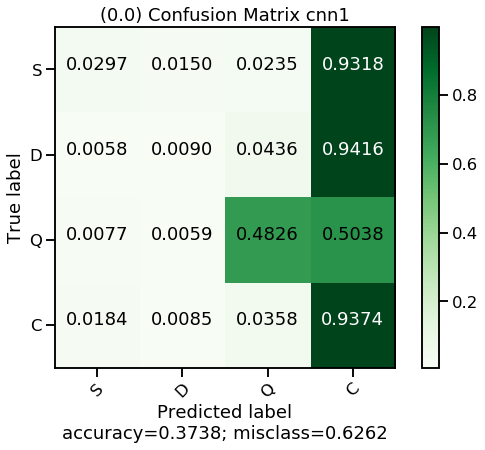

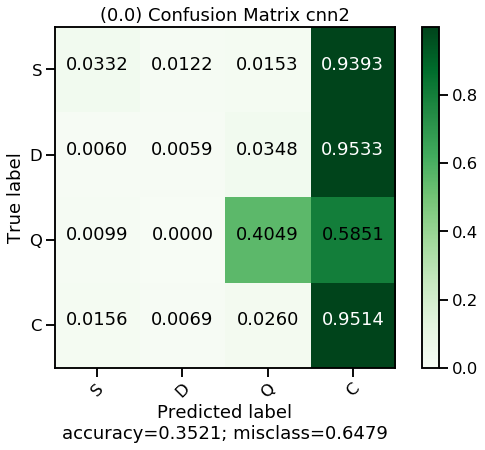

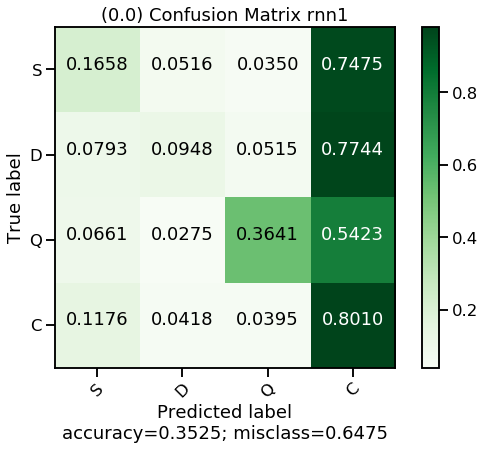

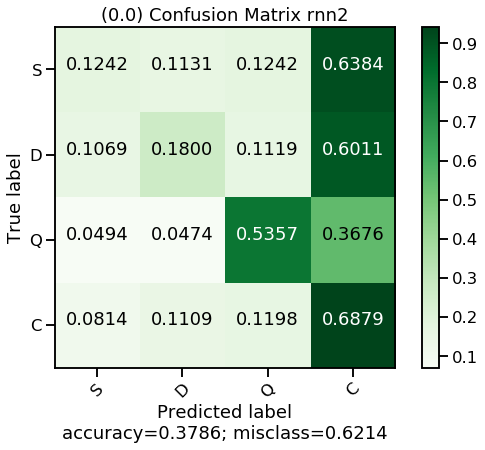

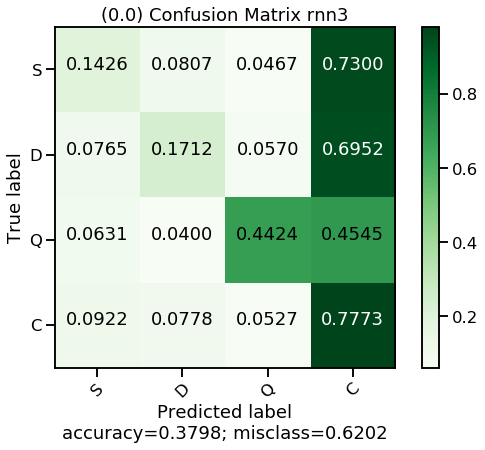

In [24]:
for key in confusions.keys():
    temp=np.sum(confusions[key], axis=0)/5.0
    plot_confusion_matrix(temp, ['S','D','Q','C'], "(0.0) Confusion Matrix "+str(key), cmap='Greens')

## Sin aumento Con CW

In [25]:
class_weights= compute_class_weight('balanced', np.unique(labels_train), labels_train)
print ("Pesos de clases:", class_weights)

Pesos de clases: [1.25980975 3.18168168 3.21060606 0.38752743]


In [26]:

fs_macro={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
fs_none={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
accs={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
confusions={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}

for i in range(1,6):    
    print ("\nEntrenando exec ", i,"\n")
    cnn1=create_ccn1(x_train.shape[1:])
    trained =train_model(cnn1, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=True)
    trained.save('../new_glove_augmented/stance_baselines/0.0_cw/cnn1_'+str(i)+'-exec.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'cnn1')
    fs_macro['cnn1'].append(f1_ma_t)
    fs_none['cnn1'].append(f1_t)
    accs['cnn1'].append(acc_t)
    confusions['cnn1'].append(matriz_t)
    
    cnn2=create_cnn2(x_train.shape[1:])
    trained =train_model(cnn2, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=True)
    trained.save('../new_glove_augmented/stance_baselines/0.0_cw/cnn2_'+str(i)+'-exec.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'cnn2')
    fs_macro['cnn2'].append(f1_ma_t)
    fs_none['cnn2'].append(f1_t)
    accs['cnn2'].append(acc_t)
    confusions['cnn2'].append(matriz_t)
    
    rnn1=create_complex_GRU_2(128,64,"adam",x_train.shape[1:])
    trained =train_model(rnn1, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=True)
    trained.save('../new_glove_augmented/stance_baselines/0.0_cw/rnn1_'+str(i)+'-exec.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'rnn1')
    fs_macro['rnn1'].append(f1_ma_t)
    fs_none['rnn1'].append(f1_t)
    accs['rnn1'].append(acc_t)
    confusions['rnn1'].append(matriz_t)
    
    rnn2=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    trained =train_model(rnn2, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=True)
    trained.save('../new_glove_augmented/stance_baselines/0.0_cw/rnn2_'+str(i)+'-exec.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'rnn2')
    fs_macro['rnn2'].append(f1_ma_t)
    fs_none['rnn2'].append(f1_t)
    accs['rnn2'].append(acc_t)
    confusions['rnn2'].append(matriz_t)
    
    rnn3=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    trained =train_model(rnn3, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=False)
    trained.save('../new_glove_augmented/stance_baselines/0.0_cw/rnn3_'+str(i)+'-exec.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'rnn3')
    fs_macro['rnn3'].append(f1_ma_t)
    fs_none['rnn3'].append(f1_t)
    accs['rnn3'].append(acc_t)
    confusions['rnn3'].append(matriz_t)



Entrenando exec  1 


Accuracy sobre Train cnn1 : 0.818546484190656
F1-score None sobre Train cnn1 : [0.68259804 0.81585678 0.84238411 0.85735821]
F1-score macro sobre Train cnn1 : 0.799549282203097

Accuracy sobre Val cnn1 : 0.6583629893238434
F1-score None sobre Val cnn1 : [0.56944444 0.06666667 0.66666667 0.74850299]
F1-score macro sobre Val cnn1 : 0.5128201929474384

Accuracy sobre Test cnn1 : 0.6797257590597453
F1-score None sobre Test cnn1 : [0.12413793 0.08108108 0.55276382 0.80516129]
F1-score macro sobre Test cnn1 : 0.3907860303834054

Accuracy sobre Train cnn2 : 0.7800849457291175
F1-score None sobre Train cnn2 : [0.67862797 0.82797203 0.73969376 0.81841738]
F1-score macro sobre Train cnn2 : 0.766177783644071

Accuracy sobre Val cnn2 : 0.6548042704626335
F1-score None sobre Val cnn2 : [0.55629139 0.11764706 0.65625    0.72727273]
F1-score macro sobre Val cnn2 : 0.5143652942061834

Accuracy sobre Test cnn2 : 0.6679725759059746
F1-score None sobre Test cnn2 : [0.13559322 0.128


Accuracy sobre Test cnn1 : 0.6709108716944172
F1-score None sobre Test cnn1 : [0.1686747  0.11940299 0.5751073  0.7899271 ]
F1-score macro sobre Test cnn1 : 0.41327802101238964

Accuracy sobre Train cnn2 : 0.7718263331760264
F1-score None sobre Train cnn2 : [0.67879418 0.76983095 0.76849642 0.80889788]
F1-score macro sobre Train cnn2 : 0.7565048561924426

Accuracy sobre Val cnn2 : 0.6619217081850534
F1-score None sobre Val cnn2 : [0.57142857 0.22222222 0.66666667 0.72782875]
F1-score macro sobre Val cnn2 : 0.5470365516237075

Accuracy sobre Test cnn2 : 0.6209598432908913
F1-score None sobre Test cnn2 : [0.06796117 0.12987013 0.59130435 0.75619835]
F1-score macro sobre Test cnn2 : 0.3863334974630497

Accuracy sobre Train rnn1 : 0.5825861255309108
F1-score None sobre Train rnn1 : [0.61924198 0.45744681 0.5471226  0.61658031]
F1-score macro sobre Train rnn1 : 0.5600979260168074

Accuracy sobre Val rnn1 : 0.4412811387900356
F1-score None sobre Val rnn1 : [0.50724638 0.12307692 0.41904762 

In [27]:
for key in fs_none.keys():
    temp=np.zeros(4)
    for result in fs_none[key]:
        temp+=result
    print ("(0.0_cw) F1-score promedio para",key,":" ,temp/5)

print ("")
for key in fs_macro.keys():
    temp=np.sum(fs_macro[key])
    print ("(0.0_cw) F1-score macro promedio para",key,":" ,temp/5, "desvest: ",np.std(fs_macro[key]))

print ("")
for key in accs.keys():
    temp=np.sum(accs[key])
    print ("(0.0_cw) Accuracy promedio para",key,":" ,temp/5)

(0.0_cw) F1-score promedio para cnn1 : [0.13172546 0.07487868 0.57135878 0.77640442]
(0.0_cw) F1-score promedio para cnn2 : [0.12209692 0.12345571 0.59226519 0.78024825]
(0.0_cw) F1-score promedio para rnn1 : [0.10841875 0.15405914 0.41065708 0.5887635 ]
(0.0_cw) F1-score promedio para rnn2 : [0.15529321 0.16998607 0.41206969 0.48007488]
(0.0_cw) F1-score promedio para rnn3 : [0.12077285 0.09418979 0.45371751 0.79709008]

(0.0_cw) F1-score macro promedio para cnn1 : 0.3885918354108574 desvest:  0.019489795758418575
(0.0_cw) F1-score macro promedio para cnn2 : 0.40451651658166854 desvest:  0.014392043914130239
(0.0_cw) F1-score macro promedio para rnn1 : 0.3154746140988717 desvest:  0.017474352154560977
(0.0_cw) F1-score macro promedio para rnn2 : 0.30435596246334845 desvest:  0.008908010611336427
(0.0_cw) F1-score macro promedio para rnn3 : 0.366442557765954 desvest:  0.02059998585458692

(0.0_cw) Accuracy promedio para cnn1 : 0.653281096963761
(0.0_cw) Accuracy promedio para cnn2 : 0.

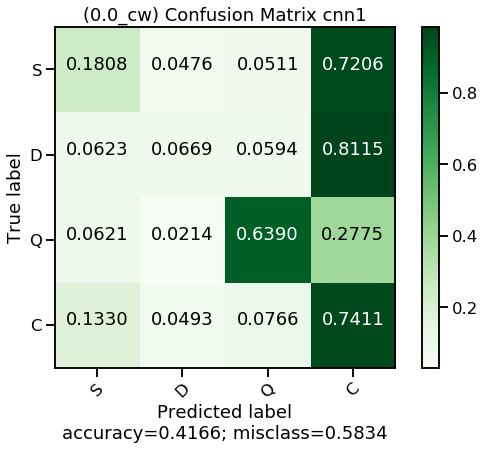

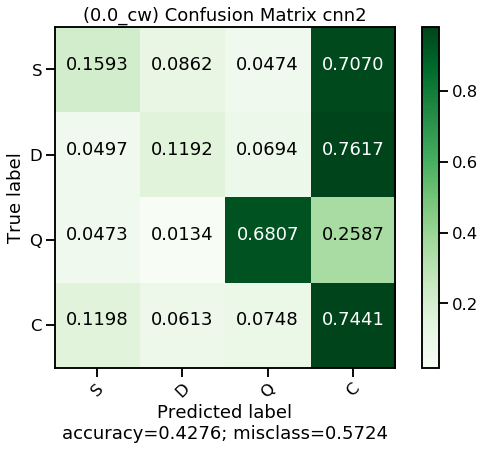

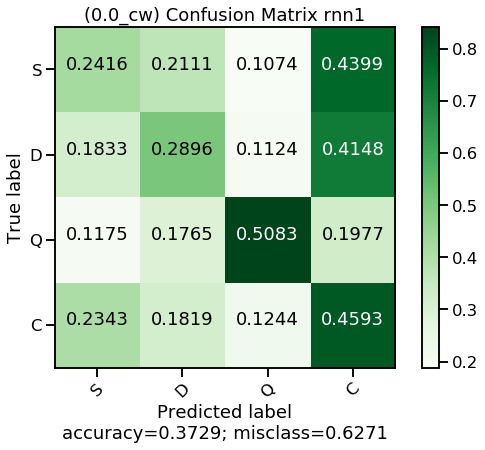

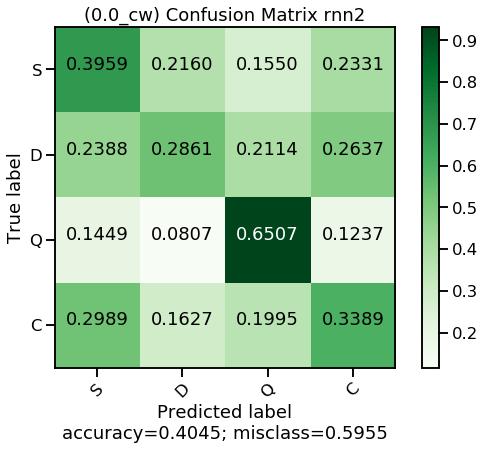

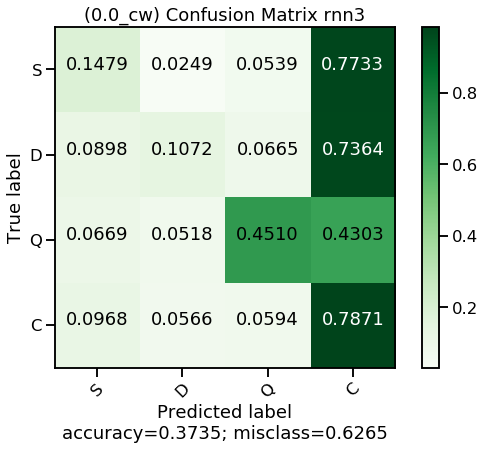

In [28]:
for key in confusions.keys():
    temp=np.sum(confusions[key], axis=0)/5.0
    plot_confusion_matrix(temp, ['S','D','Q','C'], "(0.0_cw) Confusion Matrix "+str(key), cmap='Greens')

In [29]:
class_weights

array([1.25980975, 3.18168168, 3.21060606, 0.38752743])

# Aumento de datos 

### 0.15

In [42]:
prob= 0.15
TOPN = 1

fs_macro={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
fs_none={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
accs={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
confusions={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}

aum_weight=det_samples(train['Label'], dict_cl)

for i in range(1,6): 
    macro_augmented=[]
    print ("\n--------------------------------------------------------")
    print ("\nGenerando ejemplos en base a probabilidad --> ", prob,"\t\tEjecución",i)
    print ("--------------------------------------------------------")
    for clase in aum_weight:
        start_time=time.time()
        print ("\n\nGenerando", aum_weight[clase], "nuevos ejemplos para la clase", clase)
        muestras, dict_aumentos=aumentar_clase(clase, aum_weight[clase], tags, prob, TOPN)
        macro_augmented+=muestras
        print ("Resumen de modificaciones:", dict_aumentos)
        elapsed_time= time.time() - start_time
        print ("Este proceso tomó", elapsed_time, "seg")   

    macro_augmented = np.asarray(macro_augmented, dtype=object)
    np.random.shuffle(macro_augmented)
    np.save('../new_glove_augmented/stance/Aumento_'+str(i)+'-run_'+str(prob)+'_app1_Top'+str(TOPN)+'.npy', macro_augmented)
    
    


--------------------------------------------------------

Generando ejemplos en base a probabilidad -->  0.15 		Ejecución 1
--------------------------------------------------------


Generando 2404 nuevos ejemplos para la clase questioning
Consultando por la clase questioning
Entrega label 2
pre_str ['user', 'user', 'clarified', 'that', 'earlier', '.', 'cheers'] <class 'list'> 7
['NN', 'NN', 'VBN', 'IN', 'RBR', '.', 'NNS']
pre_str ['user', 'user', 'any', 'chance', 'that', "'", 's', 'being', 'said', 'for', 'fear', 'of', 'retribution', '?'] <class 'list'> 14
['NN', 'NN', 'DT', 'NN', 'IN', "''", 'NN', 'VBG', 'VBD', 'IN', 'NN', 'IN', 'NN', '.']


IndexError: boolean index did not match indexed array along dimension 0; dimension is 7237 but corresponding boolean dimension is 6712

In [43]:
M_GLOVE_space.shape

(7237, 200)

In [37]:
prob= 0.5
TOPN = 1

fs_macro={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
fs_none={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
accs={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
confusions={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}

aum_weight=det_samples(train['Label'], dict_cl)

for i in range(1,6): 
    macro_augmented=[]
    print ("\n--------------------------------------------------------")
    print ("\nGenerando ejemplos en base a probabilidad --> ", prob,"\t\tEjecución",i)
    print ("--------------------------------------------------------")
    for clase in aum_weight:
        start_time=time.time()
        print ("\n\nGenerando", aum_weight[clase], "nuevos ejemplos para la clase", clase)
        muestras, dict_aumentos=aumentar_clase(clase, aum_weight[clase], tags, prob, TOPN)
        macro_augmented+=muestras
        print ("Resumen de modificaciones:", dict_aumentos)
        elapsed_time= time.time() - start_time
        print ("Este proceso tomó", elapsed_time, "seg")   

    macro_augmented = np.asarray(macro_augmented, dtype=object)
    np.random.shuffle(macro_augmented)
    np.save('../new_glove_augmented/stance/Aumento_'+str(i)+'-run_'+str(prob)+'_app1_Top'+str(TOPN)+'.npy', macro_augmented)
    
    


--------------------------------------------------------

Generando ejemplos en base a probabilidad -->  0.5 		Ejecución 1
--------------------------------------------------------


Generando 2404 nuevos ejemplos para la clase questioning
Consultando por la clase questioning
Entrega label 2
Sentencia original:	 ['user' 'user' 'clarified' 'that' 'earlier' '.' 'cheers']
Sentencia final: 2
['user', 'user', 'clarified', 'that', 'earlier', '.', 'cigars']

Sentencia original:	 ['user' 'user' 'any' 'chance' 'that' "'" 's' 'being' 'said' 'for' 'fear'
 'of' 'retribution' '?']
Sentencia final: 2
['user', 'user', 'any', 'link', 'that', "'", 's', 'fucking', 'said', 'for', 'dredd', 'of', 'retribution', '?']

Sentencia original:	 ['user' 'user' 'user' 'user' 'ah' 'true' '.' 'problem' 'now' 'is' 'we' "'"
 'll' 'probably' 'only' 'get' 'coroner' "'" 's' 'details' 'they' 'won' "'"
 't' 'make' 'it' '.']
Sentencia final: 2
['user', 'user', 'user', 'user', 'gelukkig', 'social', '.', 'nothing', 'now', 'is'

# terms modificados promedio 3.750104123281966 términos por sentencia
Largo de sentencia promedio 19.076634735526863 términos por sentencia
para esta ejecución se debiesen reemplazar 13321  de 26842 terminos
Resumen de modificaciones: {'JJ': 770, 'NN': 4945, 'VBZ': 410, 'VBD': 326, 'VB': 579, 'NNS': 970, 'VBN': 307, 'VBG': 501, 'VBP': 161, 'JJR': 20, 'JJS': 15}
Este proceso tomó 22.582306146621704 seg

--------------------------------------------------------

Generando ejemplos en base a probabilidad -->  0.5 		Ejecución 2
--------------------------------------------------------


Generando 2404 nuevos ejemplos para la clase questioning
Consultando por la clase questioning
Entrega label 2
Sentencia original:	 ['user' 'user' 'clarified' 'that' 'earlier' '.' 'cheers']
Sentencia final: 2
['user', 'user', 'commented', 'that', 'earlier', '.', 'cheers']

Sentencia original:	 ['user' 'user' 'any' 'chance' 'that' "'" 's' 'being' 'said' 'for' 'fear'
 'of' 'retribution' '?']
Sentencia final: 2
[

# terms modificados promedio 3.736359850062474 términos por sentencia
Largo de sentencia promedio 19.150354019158684 términos por sentencia
para esta ejecución se debiesen reemplazar 13377  de 26986 terminos
Resumen de modificaciones: {'NN': 4916, 'VBZ': 458, 'VB': 578, 'JJ': 755, 'VBN': 307, 'NNS': 976, 'VBG': 474, 'VBP': 163, 'VBD': 306, 'JJR': 25, 'JJS': 13}
Este proceso tomó 22.540894269943237 seg

--------------------------------------------------------

Generando ejemplos en base a probabilidad -->  0.5 		Ejecución 3
--------------------------------------------------------


Generando 2404 nuevos ejemplos para la clase questioning
Consultando por la clase questioning
Entrega label 2
Sentencia original:	 ['user' 'user' 'clarified' 'that' 'earlier' '.' 'cheers']
Sentencia final: 2
['user', 'user', 'commented', 'that', 'earlier', '.', 'cigars']

Sentencia original:	 ['user' 'user' 'any' 'chance' 'that' "'" 's' 'being' 'said' 'for' 'fear'
 'of' 'retribution' '?']
Sentencia final: 2
[

# terms modificados promedio 3.7351103706788837 términos por sentencia
Largo de sentencia promedio 19.129112869637652 términos por sentencia
para esta ejecución se debiesen reemplazar 13384  de 26858 terminos
Resumen de modificaciones: {'NN': 4847, 'VBZ': 453, 'VB': 562, 'JJ': 794, 'NNS': 985, 'VBG': 451, 'VBN': 339, 'VBD': 322, 'VBP': 181, 'JJS': 12, 'JJR': 22}
Este proceso tomó 22.810293197631836 seg

--------------------------------------------------------

Generando ejemplos en base a probabilidad -->  0.5 		Ejecución 4
--------------------------------------------------------


Generando 2404 nuevos ejemplos para la clase questioning
Consultando por la clase questioning
Entrega label 2
Sentencia original:	 ['user' 'user' 'any' 'chance' 'that' "'" 's' 'being' 'said' 'for' 'fear'
 'of' 'retribution' '?']
Sentencia final: 2
['user', 'user', 'any', 'enter', 'that', "'", 's', 'being', 'got', 'for', 'fear', 'of', 'retribution', '?']

Sentencia original:	 ['user' 'user' 'user' 'how' 'stup

# terms modificados promedio 3.736359850062474 términos por sentencia
Largo de sentencia promedio 18.98667221990837 términos por sentencia
para esta ejecución se debiesen reemplazar 13389  de 26772 terminos
Resumen de modificaciones: {'VBG': 478, 'NN': 4887, 'VBZ': 445, 'VBD': 330, 'VB': 565, 'NNS': 984, 'JJ': 793, 'VBP': 159, 'VBN': 299, 'JJS': 17, 'JJR': 14}
Este proceso tomó 22.790025234222412 seg

--------------------------------------------------------

Generando ejemplos en base a probabilidad -->  0.5 		Ejecución 5
--------------------------------------------------------


Generando 2404 nuevos ejemplos para la clase questioning
Consultando por la clase questioning
Entrega label 2
Sentencia original:	 ['user' 'user' 'any' 'chance' 'that' "'" 's' 'being' 'said' 'for' 'fear'
 'of' 'retribution' '?']
Sentencia final: 2
['user', 'user', 'any', 'chance', 'that', "'", 'think', 'doing', 'were', 'for', 'fear', 'of', 'retribution', '?']

Sentencia original:	 ['user' 'user' 'user' 'user' 

# terms modificados promedio 3.6793002915451893 términos por sentencia
Largo de sentencia promedio 18.86755518533944 términos por sentencia
para esta ejecución se debiesen reemplazar 13194  de 26416 terminos
Resumen de modificaciones: {'VBG': 447, 'JJ': 752, 'VBD': 303, 'NN': 4841, 'VB': 564, 'VBN': 336, 'NNS': 974, 'VBZ': 428, 'VBP': 153, 'JJR': 22, 'JJS': 14}
Este proceso tomó 22.45628023147583 seg


In [38]:
prob= 0.85
TOPN = 1

fs_macro={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
fs_none={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
accs={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
confusions={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}

aum_weight=det_samples(train['Label'], dict_cl)

for i in range(1,6): 
    macro_augmented=[]
    print ("\n--------------------------------------------------------")
    print ("\nGenerando ejemplos en base a probabilidad --> ", prob,"\t\tEjecución",i)
    print ("--------------------------------------------------------")
    for clase in aum_weight:
        start_time=time.time()
        print ("\n\nGenerando", aum_weight[clase], "nuevos ejemplos para la clase", clase)
        muestras, dict_aumentos=aumentar_clase(clase, aum_weight[clase], tags, prob, TOPN)
        macro_augmented+=muestras
        print ("Resumen de modificaciones:", dict_aumentos)
        elapsed_time= time.time() - start_time
        print ("Este proceso tomó", elapsed_time, "seg")   

    macro_augmented = np.asarray(macro_augmented, dtype=object)
    np.random.shuffle(macro_augmented)
    np.save('../new_glove_augmented/stance/Aumento_'+str(i)+'-run_'+str(prob)+'_app1_Top'+str(TOPN)+'.npy', macro_augmented)
    
    


--------------------------------------------------------

Generando ejemplos en base a probabilidad -->  0.85 		Ejecución 1
--------------------------------------------------------


Generando 2404 nuevos ejemplos para la clase questioning
Consultando por la clase questioning
Entrega label 2
Sentencia original:	 ['user' 'user' 'clarified' 'that' 'earlier' '.' 'cheers']
Sentencia final: 2
['user', 'user', 'commented', 'that', 'earlier', '.', 'cigars']

Sentencia original:	 ['user' 'user' 'any' 'chance' 'that' "'" 's' 'being' 'said' 'for' 'fear'
 'of' 'retribution' '?']
Sentencia final: 2
['user', 'user', 'any', 'app', 'that', "'", 's', 'talking', 'were', 'for', 'evil', 'of', 'retribution', '?']

Sentencia original:	 ['user' 'user' 'user' 'user' 'ah' 'true' '.' 'problem' 'now' 'is' 'we' "'"
 'll' 'probably' 'only' 'get' 'coroner' "'" 's' 'details' 'they' 'won' "'"
 't' 'make' 'it' '.']
Sentencia final: 2
['user', 'user', 'user', 'user', 'ok', 'true', '.', 'life', 'now', 'does', 'we', "'

# terms modificados promedio 5.987505206164098 términos por sentencia
Largo de sentencia promedio 18.416909620991255 términos por sentencia
para esta ejecución se debiesen reemplazar 21376  de 25193 terminos
Resumen de modificaciones: {'VBG': 737, 'NN': 7900, 'JJ': 1264, 'VBZ': 670, 'VBD': 504, 'VB': 927, 'VBN': 499, 'NNS': 1575, 'VBP': 239, 'JJR': 37, 'JJS': 24}
Este proceso tomó 33.08356189727783 seg

--------------------------------------------------------

Generando ejemplos en base a probabilidad -->  0.85 		Ejecución 2
--------------------------------------------------------


Generando 2404 nuevos ejemplos para la clase questioning
Consultando por la clase questioning
Entrega label 2
Sentencia original:	 ['user' 'user' 'clarified' 'that' 'earlier' '.' 'cheers']
Sentencia final: 2
['user', 'user', 'clarified', 'that', 'earlier', '.', 'cigars']

Sentencia original:	 ['user' 'user' 'any' 'chance' 'that' "'" 's' 'being' 'said' 'for' 'fear'
 'of' 'retribution' '?']
Sentencia final: 2

# terms modificados promedio 5.998334027488546 términos por sentencia
Largo de sentencia promedio 18.433985839233653 términos por sentencia
para esta ejecución se debiesen reemplazar 21349  de 25208 terminos
Resumen de modificaciones: {'VBG': 754, 'NN': 7852, 'JJ': 1258, 'VBZ': 687, 'VBD': 518, 'VB': 918, 'VBN': 512, 'NNS': 1593, 'VBP': 256, 'JJS': 24, 'JJR': 30}
Este proceso tomó 33.01363015174866 seg

--------------------------------------------------------

Generando ejemplos en base a probabilidad -->  0.85 		Ejecución 3
--------------------------------------------------------


Generando 2404 nuevos ejemplos para la clase questioning
Consultando por la clase questioning
Entrega label 2
Sentencia original:	 ['user' 'user' 'clarified' 'that' 'earlier' '.' 'cheers']
Sentencia final: 2
['user', 'user', 'commented', 'that', 'earlier', '.', 'cheers']

Sentencia original:	 ['user' 'user' 'any' 'chance' 'that' "'" 's' 'being' 'said' 'for' 'fear'
 'of' 'retribution' '?']
Sentencia final: 2

# terms modificados promedio 6.032486463973345 términos por sentencia
Largo de sentencia promedio 18.457725947521865 términos por sentencia
para esta ejecución se debiesen reemplazar 21541  de 25259 terminos
Resumen de modificaciones: {'NN': 7905, 'JJ': 1290, 'VBZ': 684, 'VBD': 501, 'VB': 925, 'VBN': 500, 'NNS': 1603, 'VBG': 750, 'VBP': 268, 'JJR': 34, 'JJS': 24}
Este proceso tomó 33.25094676017761 seg

--------------------------------------------------------

Generando ejemplos en base a probabilidad -->  0.85 		Ejecución 4
--------------------------------------------------------


Generando 2404 nuevos ejemplos para la clase questioning
Consultando por la clase questioning
Entrega label 2
Sentencia original:	 ['user' 'user' 'clarified' 'that' 'earlier' '.' 'cheers']
Sentencia final: 2
['user', 'user', 'commented', 'that', 'earlier', '.', 'cigars']

Sentencia original:	 ['user' 'user' 'any' 'chance' 'that' "'" 's' 'being' 'said' 'for' 'fear'
 'of' 'retribution' '?']
Sentencia final: 2

# terms modificados promedio 6.024156601416077 términos por sentencia
Largo de sentencia promedio 18.526030820491464 términos por sentencia
para esta ejecución se debiesen reemplazar 21572  de 25382 terminos
Resumen de modificaciones: {'NN': 7918, 'JJ': 1266, 'VBZ': 677, 'VBD': 508, 'VB': 931, 'VBN': 510, 'NNS': 1594, 'VBG': 741, 'VBP': 257, 'JJS': 28, 'JJR': 34}
Este proceso tomó 33.62799692153931 seg

--------------------------------------------------------

Generando ejemplos en base a probabilidad -->  0.85 		Ejecución 5
--------------------------------------------------------


Generando 2404 nuevos ejemplos para la clase questioning
Consultando por la clase questioning
Entrega label 2
Sentencia original:	 ['user' 'user' 'clarified' 'that' 'earlier' '.' 'cheers']
Sentencia final: 2
['user', 'user', 'commented', 'that', 'earlier', '.', 'cigars']

Sentencia original:	 ['user' 'user' 'any' 'chance' 'that' "'" 's' 'being' 'said' 'for' 'fear'
 'of' 'retribution' '?']
Sentencia final: 2

# terms modificados promedio 6.028321532694711 términos por sentencia
Largo de sentencia promedio 18.46064139941691 términos por sentencia
para esta ejecución se debiesen reemplazar 21540  de 25259 terminos
Resumen de modificaciones: {'VBG': 742, 'NN': 7935, 'JJ': 1278, 'VBZ': 689, 'VBD': 509, 'VB': 920, 'VBN': 504, 'NNS': 1584, 'VBP': 257, 'JJS': 23, 'JJR': 33}
Este proceso tomó 34.429346799850464 seg


## Baselines 

In [22]:
del embeddings_index

### 0.15

In [23]:
prob=0.15 
TOPN=1

fs_macro={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
fs_none={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
accs={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
confusions={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}


for i in range(1,6):
    print ("----------------------- Entrenando running ", i,"-----------------------")
    macro_augmented=np.load('../new_glove_augmented/stance/Aumento_'+str(i)+'-run_'+str(prob)+'_app1_Top'+str(TOPN)+'.npy', allow_pickle=True)
    
    ids_train=macro_augmented[:,0]
    tws_train=macro_augmented[:,1]
    labels_train=macro_augmented[:,2]
    class_weights= compute_class_weight('balanced', np.unique(labels_train), labels_train)
    print ("Pesos de clases:", class_weights)

    etiq=labels_train.copy()
    sentences = tws_train
    n_labels = np.array(etiq)
    y_train=to_categorical(n_labels,num_classes=4)
    
    input_ids = []
    for sent in sentences:
        encoded_tok=[]
        for wd in sent:
            try: 
                encoded_tok.append(Word2Index_valid[wd])
            except: 
                continue 
        input_ids.append(encoded_tok)
    
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                              value=0, truncating="post", padding="post")
    
    shape=np.asarray(input_ids).shape
    x_train=np.zeros((shape[0], shape[1], g_dim))
    j=0
    for in_id in input_ids:
        x_train[j]=M_GLOVE_space[in_id]
        j+=1
        
    ###########################################################
    ############################################################
    ############################################################
    
    cnn1=create_ccn1(x_train.shape[1:])
    trained =train_model(cnn1, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=True)
    trained.save('../new_glove_augmented/stance_baselines/0.15/cnn1_'+str(i)+'-exec_app1_Top_'+str(TOPN)+'.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'cnn1')
    fs_macro['cnn1'].append(f1_ma_t)
    fs_none['cnn1'].append(f1_t)
    accs['cnn1'].append(acc_t)
    confusions['cnn1'].append(matriz_t)
    
    cnn2=create_cnn2(x_train.shape[1:])
    trained =train_model(cnn2, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=True)
    trained.save('../new_glove_augmented/stance_baselines/0.15/cnn2_'+str(i)+'-exec_app1_Top_'+str(TOPN)+'.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'cnn2')
    fs_macro['cnn2'].append(f1_ma_t)
    fs_none['cnn2'].append(f1_t)
    accs['cnn2'].append(acc_t)
    confusions['cnn2'].append(matriz_t)
    
    rnn1=create_complex_GRU_2(128,64,"adam",x_train.shape[1:])
    trained =train_model(rnn1, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=True)
    trained.save('../new_glove_augmented/stance_baselines/0.15/rnn1_'+str(i)+'-exec_app1_Top_'+str(TOPN)+'.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'rnn1')
    fs_macro['rnn1'].append(f1_ma_t)
    fs_none['rnn1'].append(f1_t)
    accs['rnn1'].append(acc_t)
    confusions['rnn1'].append(matriz_t)
    
    rnn2=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    trained =train_model(rnn2, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=True)
    trained.save('../new_glove_augmented/stance_baselines/0.15/rnn2_'+str(i)+'-exec_app1_Top_'+str(TOPN)+'.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'rnn2')
    fs_macro['rnn2'].append(f1_ma_t)
    fs_none['rnn2'].append(f1_t)
    accs['rnn2'].append(acc_t)
    confusions['rnn2'].append(matriz_t)
    
    rnn3=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    trained =train_model(rnn3, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=False)
    trained.save('../new_glove_augmented/stance_baselines/0.15/rnn3_'+str(i)+'-exec_app1_Top_'+str(TOPN)+'.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'rnn3')
    fs_macro['rnn3'].append(f1_ma_t)
    fs_none['rnn3'].append(f1_t)
    accs['rnn3'].append(acc_t)
    confusions['rnn3'].append(matriz_t)


----------------------- Entrenando running  1 -----------------------
Pesos de clases: [1. 1. 1. 1.]





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Accuracy sobre Train cnn1 : 0.9627834674469642
F1-score None sobre Train cnn1 : [0.93943371 0.98826119 0.99086257 0.93285841]
F1-score macro sobre Train cnn1 : 0.9628539728052914

Accuracy sobre Val cnn1 : 0.7188612099644128
F1-score None sobre Val cnn1 : [0.62121212 0.36363636 0.65306122 0.78551532]
F1-score macro sobre Val cnn1 : 0.6058562574181356

Accuracy sobre Test cnn1 : 0.7286973555337904
F1-score None sobre Test cnn1 : [0.09375    0.13793103 0.56043956 0.84034653]
F1-score macro sobre Test cnn1 : 0.4081167823939461

Accuracy sobre Train cnn2 : 0.9548280907095831
F1-score None sobre Train cnn2 : [0.920549   0.98633631 0.9897511  0.92238079]
F1-score macro sobre Trai

Pesos de clases: [1. 1. 1. 1.]

Accuracy sobre Train cnn1 : 0.9473299195318216
F1-score None sobre Train cnn1 : [0.90423427 0.98640206 0.98781597 0.9103284 ]
F1-score macro sobre Train cnn1 : 0.947195173333611

Accuracy sobre Val cnn1 : 0.6903914590747331
F1-score None sobre Val cnn1 : [0.5210084  0.2        0.65384615 0.77628032]
F1-score macro sobre Val cnn1 : 0.5377837201644082

Accuracy sobre Test cnn1 : 0.7404505386875612
F1-score None sobre Test cnn1 : [0.02083333 0.18487395 0.53714286 0.84382567]
F1-score macro sobre Test cnn1 : 0.3966689514788966

Accuracy sobre Train cnn2 : 0.9596744696415508
F1-score None sobre Train cnn2 : [0.93705528 0.98929889 0.98672969 0.92577697]
F1-score macro sobre Train cnn2 : 0.9597152064121512

Accuracy sobre Val cnn2 : 0.708185053380783
F1-score None sobre Val cnn2 : [0.6122449  0.15384615 0.61538462 0.78285714]
F1-score macro sobre Val cnn2 : 0.541083202511774

Accuracy sobre Test cnn2 : 0.7247796278158668
F1-score None sobre Test cnn2 : [0.11764

In [24]:
for key in fs_none.keys():
    temp=np.zeros(4)
    for result in fs_none[key]:
        temp+=result
    print ("(0.15) app1 F1-score promedio para",key,":" ,temp/5)

print ("")
for key in fs_macro.keys():
    temp=np.sum(fs_macro[key])
    print ("(0.15) app1 F1-score macro promedio para",key,":" ,temp/5, "desvest: ",np.std(fs_macro[key]))

print ("")
for key in accs.keys():
    temp=np.sum(accs[key])
    print ("(0.15) app1 Accuracy promedio para",key,":" ,temp/5)

(0.15) app1 F1-score promedio para cnn1 : [0.0537254  0.16314146 0.55176416 0.84018157]
(0.15) app1 F1-score promedio para cnn2 : [0.0506592  0.18720457 0.55868841 0.8387387 ]
(0.15) app1 F1-score promedio para rnn1 : [0.13299804 0.16295143 0.49696103 0.73789036]
(0.15) app1 F1-score promedio para rnn2 : [0.0926702  0.19019357 0.44182552 0.77172088]
(0.15) app1 F1-score promedio para rnn3 : [0.08904813 0.18583306 0.47683743 0.79759923]

(0.15) app1 F1-score macro promedio para cnn1 : 0.40220314648407723 desvest:  0.008066694488479265
(0.15) app1 F1-score macro promedio para cnn2 : 0.4088227198744875 desvest:  0.014890858026472867
(0.15) app1 F1-score macro promedio para rnn1 : 0.38270021439095575 desvest:  0.009221524959631154
(0.15) app1 F1-score macro promedio para rnn2 : 0.3741025433298768 desvest:  0.020525876054378726
(0.15) app1 F1-score macro promedio para rnn3 : 0.38732946382201433 desvest:  0.02327909434392991

(0.15) app1 Accuracy promedio para cnn1 : 0.7318315377081293
(0.15

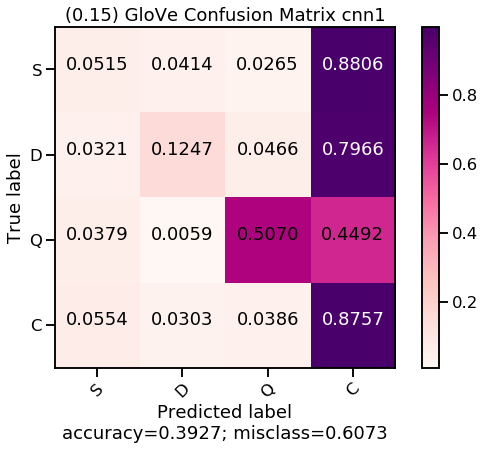

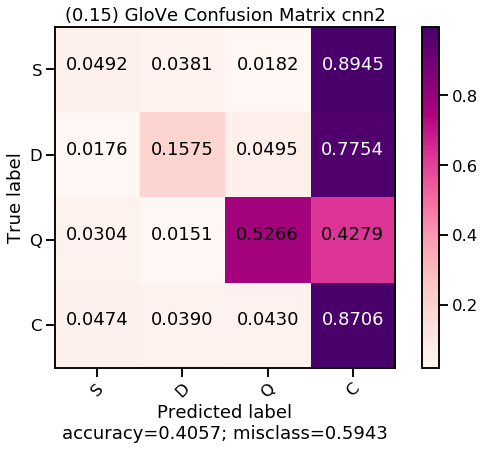

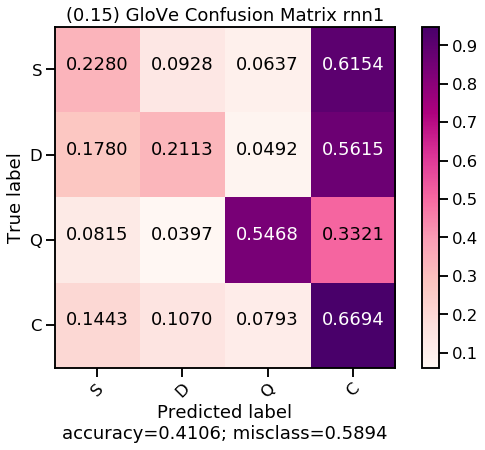

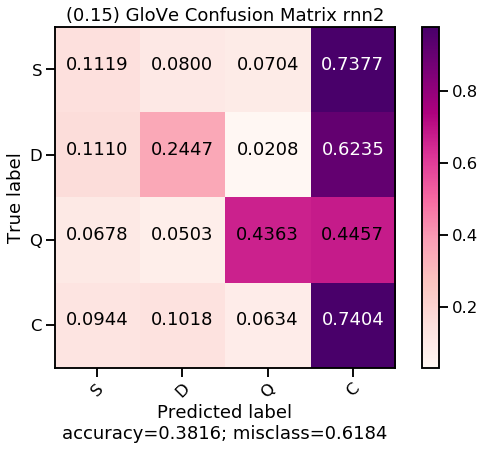

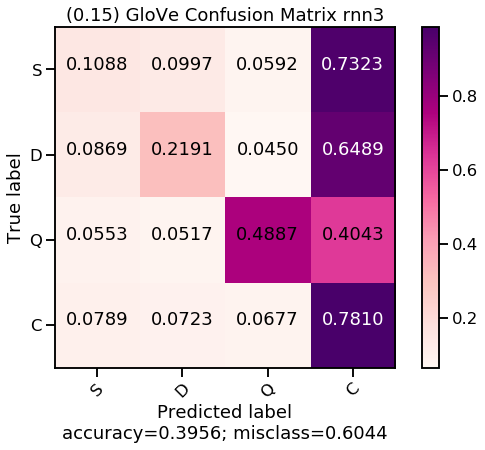

In [25]:
for key in confusions.keys():
    temp=np.sum(confusions[key], axis=0)/5.0
    plot_confusion_matrix(temp, ['S','D','Q','C'], "(0.15) GloVe Confusion Matrix "+str(key), cmap='RdPu')

### 0.5

In [26]:
prob=0.5 
TOPN=1

fs_macro={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
fs_none={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
accs={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
confusions={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}


for i in range(1,6):
    print ("----------------------- Entrenando running ", i,"-----------------------")
    macro_augmented=np.load('../new_glove_augmented/stance/Aumento_'+str(i)+'-run_'+str(prob)+'_app1_Top'+str(TOPN)+'.npy', allow_pickle=True)
    
    ids_train=macro_augmented[:,0]
    tws_train=macro_augmented[:,1]
    labels_train=macro_augmented[:,2]
    class_weights= compute_class_weight('balanced', np.unique(labels_train), labels_train)
    print ("Pesos de clases:", class_weights)

    etiq=labels_train.copy()
    sentences = tws_train
    n_labels = np.array(etiq)
    y_train=to_categorical(n_labels,num_classes=4)
    
    input_ids = []
    for sent in sentences:
        encoded_tok=[]
        for wd in sent:
            try: 
                encoded_tok.append(Word2Index_valid[wd])
            except: 
                continue 
        input_ids.append(encoded_tok)
    
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                              value=0, truncating="post", padding="post")
    
    shape=np.asarray(input_ids).shape
    x_train=np.zeros((shape[0], shape[1], g_dim))
    j=0
    for in_id in input_ids:
        x_train[j]=M_GLOVE_space[in_id]
        j+=1
        
    ###########################################################
    ############################################################
    ############################################################
    
    cnn1=create_ccn1(x_train.shape[1:])
    trained =train_model(cnn1, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=True)
    trained.save('../new_glove_augmented/stance_baselines/0.5/cnn1_'+str(i)+'-exec_app1_Top_'+str(TOPN)+'.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'cnn1')
    fs_macro['cnn1'].append(f1_ma_t)
    fs_none['cnn1'].append(f1_t)
    accs['cnn1'].append(acc_t)
    confusions['cnn1'].append(matriz_t)
    
    cnn2=create_cnn2(x_train.shape[1:])
    trained =train_model(cnn2, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=True)
    trained.save('../new_glove_augmented/stance_baselines/0.5/cnn2_'+str(i)+'-exec_app1_Top_'+str(TOPN)+'.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'cnn2')
    fs_macro['cnn2'].append(f1_ma_t)
    fs_none['cnn2'].append(f1_t)
    accs['cnn2'].append(acc_t)
    confusions['cnn2'].append(matriz_t)
    
    rnn1=create_complex_GRU_2(128,64,"adam",x_train.shape[1:])
    trained =train_model(rnn1, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=True)
    trained.save('../new_glove_augmented/stance_baselines/0.5/rnn1_'+str(i)+'-exec_app1_Top_'+str(TOPN)+'.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'rnn1')
    fs_macro['rnn1'].append(f1_ma_t)
    fs_none['rnn1'].append(f1_t)
    accs['rnn1'].append(acc_t)
    confusions['rnn1'].append(matriz_t)
    
    rnn2=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    trained =train_model(rnn2, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=True)
    trained.save('../new_glove_augmented/stance_baselines/0.5/rnn2_'+str(i)+'-exec_app1_Top_'+str(TOPN)+'.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'rnn2')
    fs_macro['rnn2'].append(f1_ma_t)
    fs_none['rnn2'].append(f1_t)
    accs['rnn2'].append(acc_t)
    confusions['rnn2'].append(matriz_t)
    
    rnn3=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    trained =train_model(rnn3, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=False)
    trained.save('../new_glove_augmented/stance_baselines/0.5/rnn3_'+str(i)+'-exec_app1_Top_'+str(TOPN)+'.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'rnn3')
    fs_macro['rnn3'].append(f1_ma_t)
    fs_none['rnn3'].append(f1_t)
    accs['rnn3'].append(acc_t)
    confusions['rnn3'].append(matriz_t)


----------------------- Entrenando running  1 -----------------------
Pesos de clases: [1. 1. 1. 1.]

Accuracy sobre Train cnn1 : 0.9565654718361375
F1-score None sobre Train cnn1 : [0.92078249 0.99088257 0.99359795 0.92080584]
F1-score macro sobre Train cnn1 : 0.9565172112432133

Accuracy sobre Val cnn1 : 0.6619217081850534
F1-score None sobre Val cnn1 : [0.55384615 0.22857143 0.59090909 0.75354108]
F1-score macro sobre Val cnn1 : 0.5317169374534814

Accuracy sobre Test cnn1 : 0.6758080313418218
F1-score None sobre Test cnn1 : [0.09230769 0.20430108 0.51396648 0.80025856]
F1-score macro sobre Test cnn1 : 0.4027084532469711

Accuracy sobre Train cnn2 : 0.9391916605705926
F1-score None sobre Train cnn2 : [0.88378651 0.99126955 0.98767669 0.89186895]
F1-score macro sobre Train cnn2 : 0.9386504262993681

Accuracy sobre Val cnn2 : 0.701067615658363
F1-score None sobre Val cnn2 : [0.56451613 0.38461538 0.6557377  0.78062678]
F1-score macro sobre Val cnn2 : 0.596373999798114

Accuracy sobre 

Pesos de clases: [1. 1. 1. 1.]

Accuracy sobre Train cnn1 : 0.9564740307242136
F1-score None sobre Train cnn1 : [0.91859336 0.99266055 0.99341383 0.92132897]
F1-score macro sobre Train cnn1 : 0.9564991772626823

Accuracy sobre Val cnn1 : 0.6725978647686833
F1-score None sobre Val cnn1 : [0.51612903 0.27272727 0.60377358 0.76033058]
F1-score macro sobre Val cnn1 : 0.5382401171008486

Accuracy sobre Test cnn1 : 0.7316356513222331
F1-score None sobre Test cnn1 : [0.03636364 0.21487603 0.56382979 0.83672212]
F1-score macro sobre Test cnn1 : 0.41294789404681537

Accuracy sobre Train cnn2 : 0.9531821506949525
F1-score None sobre Train cnn2 : [0.92292834 0.99087924 0.98352345 0.91493849]
F1-score macro sobre Train cnn2 : 0.9530673785014314

Accuracy sobre Val cnn2 : 0.6903914590747331
F1-score None sobre Val cnn2 : [0.53968254 0.27272727 0.65454545 0.77437326]
F1-score macro sobre Val cnn2 : 0.5603321315020479

Accuracy sobre Test cnn2 : 0.6993143976493633
F1-score None sobre Test cnn2 : [0.0

In [27]:
for key in fs_none.keys():
    temp=np.zeros(4)
    for result in fs_none[key]:
        temp+=result
    print ("(0.5) app1 F1-score promedio para",key,":" ,temp/5)

print ("")
for key in fs_macro.keys():
    temp=np.sum(fs_macro[key])
    print ("(0.5) app1 F1-score macro promedio para",key,":" ,temp/5, "desvest: ",np.std(fs_macro[key]))

print ("")
for key in accs.keys():
    temp=np.sum(accs[key])
    print ("(0.5) app1 Accuracy promedio para",key,":" ,temp/5)

(0.5) app1 F1-score promedio para cnn1 : [0.06654088 0.1879534  0.56024321 0.82377145]
(0.5) app1 F1-score promedio para cnn2 : [0.08632468 0.19611844 0.55591159 0.82133439]
(0.5) app1 F1-score promedio para rnn1 : [0.11003027 0.19291442 0.40100493 0.72580176]
(0.5) app1 F1-score promedio para rnn2 : [0.09650875 0.21059953 0.45604259 0.73632566]
(0.5) app1 F1-score promedio para rnn3 : [0.11156619 0.17575818 0.45569041 0.73249743]

(0.5) app1 F1-score macro promedio para cnn1 : 0.4096272357115029 desvest:  0.00817361993995388
(0.5) app1 F1-score macro promedio para cnn2 : 0.41492227334183485 desvest:  0.008551632078124047
(0.5) app1 F1-score macro promedio para rnn1 : 0.35743784392685174 desvest:  0.012339116369293494
(0.5) app1 F1-score macro promedio para rnn2 : 0.37486913204243405 desvest:  0.02108187059884681
(0.5) app1 F1-score macro promedio para rnn3 : 0.3688780536633175 desvest:  0.030012974920255387

(0.5) app1 Accuracy promedio para cnn1 : 0.7108716944172381
(0.5) app1 Accura

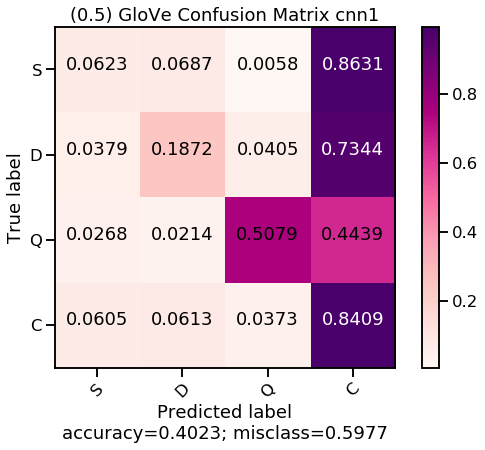

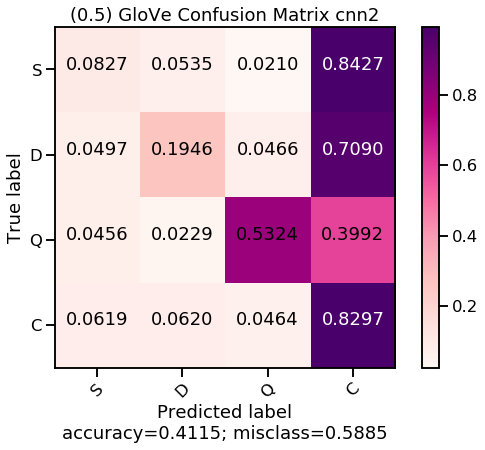

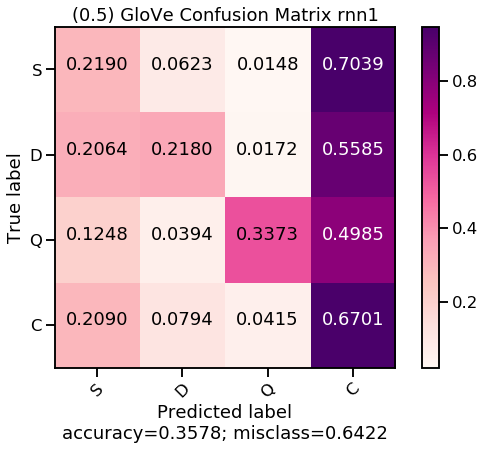

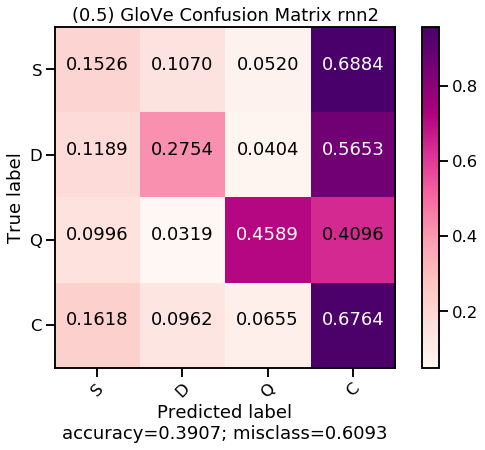

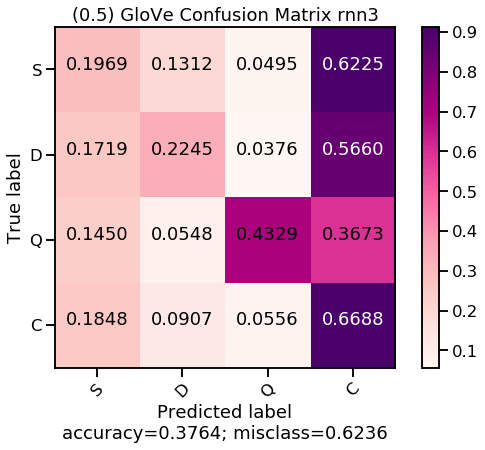

In [28]:
for key in confusions.keys():
    temp=np.sum(confusions[key], axis=0)/5.0
    plot_confusion_matrix(temp, ['S','D','Q','C'], "(0.5) GloVe Confusion Matrix "+str(key), cmap='RdPu')

### 0.85

In [29]:
prob=0.85 
TOPN=1

fs_macro={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
fs_none={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
accs={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}
confusions={'cnn1':[], 'cnn2':[], 'rnn1':[],'rnn2':[],'rnn3':[]}


for i in range(1,6):
    print ("----------------------- Entrenando running ", i,"-----------------------")
    macro_augmented=np.load('../new_glove_augmented/stance/Aumento_'+str(i)+'-run_'+str(prob)+'_app1_Top'+str(TOPN)+'.npy', allow_pickle=True)
      
    ids_train=macro_augmented[:,0]
    tws_train=macro_augmented[:,1]
    labels_train=macro_augmented[:,2]
    class_weights= compute_class_weight('balanced', np.unique(labels_train), labels_train)
    print ("Pesos de clases:", class_weights)

    etiq=labels_train.copy()
    sentences = tws_train
    n_labels = np.array(etiq)
    y_train=to_categorical(n_labels,num_classes=4)
    
    input_ids = []
    for sent in sentences:
        encoded_tok=[]
        for wd in sent:
            try: 
                encoded_tok.append(Word2Index_valid[wd])
            except: 
                continue 
        input_ids.append(encoded_tok)
    
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                              value=0, truncating="post", padding="post")
    
    shape=np.asarray(input_ids).shape
    x_train=np.zeros((shape[0], shape[1], g_dim))
    j=0
    for in_id in input_ids:
        x_train[j]=M_GLOVE_space[in_id]
        j+=1
        

    ###########################################################
    ############################################################
    ############################################################
    
    cnn1=create_ccn1(x_train.shape[1:])
    trained =train_model(cnn1, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=True)
    trained.save('../new_glove_augmented/stance_baselines/0.85/cnn1_'+str(i)+'-exec_app1_Top_'+str(TOPN)+'.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'cnn1')
    fs_macro['cnn1'].append(f1_ma_t)
    fs_none['cnn1'].append(f1_t)
    accs['cnn1'].append(acc_t)
    confusions['cnn1'].append(matriz_t)
    
    cnn2=create_cnn2(x_train.shape[1:])
    trained =train_model(cnn2, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=True)
    trained.save('../new_glove_augmented/stance_baselines/0.85/cnn2_'+str(i)+'-exec_app1_Top_'+str(TOPN)+'.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'cnn2')
    fs_macro['cnn2'].append(f1_ma_t)
    fs_none['cnn2'].append(f1_t)
    accs['cnn2'].append(acc_t)
    confusions['cnn2'].append(matriz_t)
    
    rnn1=create_complex_GRU_2(128,64,"adam",x_train.shape[1:])
    trained =train_model(rnn1, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=True)
    trained.save('../new_glove_augmented/stance_baselines/0.85/rnn1_'+str(i)+'-exec_app1_Top_'+str(TOPN)+'.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'rnn1')
    fs_macro['rnn1'].append(f1_ma_t)
    fs_none['rnn1'].append(f1_t)
    accs['rnn1'].append(acc_t)
    confusions['rnn1'].append(matriz_t)
    
    rnn2=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    trained =train_model(rnn2, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=True)
    trained.save('../new_glove_augmented/stance_baselines/0.85/rnn2_'+str(i)+'-exec_app1_Top_'+str(TOPN)+'.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'rnn2')
    fs_macro['rnn2'].append(f1_ma_t)
    fs_none['rnn2'].append(f1_t)
    accs['rnn2'].append(acc_t)
    confusions['rnn2'].append(matriz_t)
    
    rnn3=create_complex_GRU_3(256,128,64,"adam",x_train.shape[1:])
    trained =train_model(rnn3, x_train, y_train, x_val, y_val, class_weights, e=30, BS=32, verb=0, focal=False)
    trained.save('../new_glove_augmented/stance_baselines/0.85/rnn3_'+str(i)+'-exec_app1_Top_'+str(TOPN)+'.h5')
    f1_ma_t, f1_t, acc_t, matriz_t = predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, 'rnn3')
    fs_macro['rnn3'].append(f1_ma_t)
    fs_none['rnn3'].append(f1_t)
    accs['rnn3'].append(acc_t)
    confusions['rnn3'].append(matriz_t)


----------------------- Entrenando running  1 -----------------------
Pesos de clases: [1. 1. 1. 1.]

Accuracy sobre Train cnn1 : 0.9631492318946598
F1-score None sobre Train cnn1 : [0.93835616 0.99134916 0.9917988  0.9315309 ]
F1-score macro sobre Train cnn1 : 0.9632587557355476

Accuracy sobre Val cnn1 : 0.6903914590747331
F1-score None sobre Val cnn1 : [0.59541985 0.21052632 0.58181818 0.767507  ]
F1-score macro sobre Val cnn1 : 0.538817836934255

Accuracy sobre Test cnn1 : 0.7149853085210578
F1-score None sobre Test cnn1 : [0.128      0.1969697  0.50810811 0.8275    ]
F1-score macro sobre Test cnn1 : 0.4151444512694513

Accuracy sobre Train cnn2 : 0.966532553035845
F1-score None sobre Train cnn2 : [0.94922165 0.98747698 0.99306822 0.93673616]
F1-score macro sobre Train cnn2 : 0.9666257524292575

Accuracy sobre Val cnn2 : 0.6654804270462633
F1-score None sobre Val cnn2 : [0.55474453 0.22222222 0.58181818 0.74431818]
F1-score macro sobre Val cnn2 : 0.5257757778515078

Accuracy sobre 

Pesos de clases: [1. 1. 1. 1.]

Accuracy sobre Train cnn1 : 0.9658924652523775
F1-score None sobre Train cnn1 : [0.9502661  0.98835705 0.99036188 0.93488119]
F1-score macro sobre Train cnn1 : 0.9659665570546759

Accuracy sobre Val cnn1 : 0.6903914590747331
F1-score None sobre Val cnn1 : [0.6056338  0.28571429 0.56666667 0.76300578]
F1-score macro sobre Val cnn1 : 0.5552551338861687

Accuracy sobre Test cnn1 : 0.6914789422135161
F1-score None sobre Test cnn1 : [0.09815951 0.11881188 0.55454545 0.81001284]
F1-score macro sobre Test cnn1 : 0.39538242047662553

Accuracy sobre Train cnn2 : 0.9551938551572787
F1-score None sobre Train cnn2 : [0.9186434  0.98929889 0.9939748  0.91930541]
F1-score macro sobre Train cnn2 : 0.9553056284138242

Accuracy sobre Val cnn2 : 0.6832740213523132
F1-score None sobre Val cnn2 : [0.53658537 0.10526316 0.56603774 0.77929155]
F1-score macro sobre Val cnn2 : 0.49679445318274174

Accuracy sobre Test cnn2 : 0.703232125367287
F1-score None sobre Test cnn2 : [0.0

In [30]:
for key in fs_none.keys():
    temp=np.zeros(4)
    for result in fs_none[key]:
        temp+=result
    print ("(0.85) app1 F1-score promedio para",key,":" ,temp/5)

print ("")
for key in fs_macro.keys():
    temp=np.sum(fs_macro[key])
    print ("(0.85) app1 F1-score macro promedio para",key,":" ,temp/5, "desvest: ",np.std(fs_macro[key]))

print ("")
for key in accs.keys():
    temp=np.sum(accs[key])
    print ("(0.85) app1 Accuracy promedio para",key,":" ,temp/5)

(0.85) app1 F1-score promedio para cnn1 : [0.08091132 0.17126271 0.53678331 0.81780637]
(0.85) app1 F1-score promedio para cnn2 : [0.07273225 0.16756924 0.54743021 0.81144473]
(0.85) app1 F1-score promedio para rnn1 : [0.07959283 0.13707977 0.42766363 0.77143027]
(0.85) app1 F1-score promedio para rnn2 : [0.11867542 0.20741475 0.41088754 0.73429399]
(0.85) app1 F1-score promedio para rnn3 : [0.10963664 0.17152051 0.47260964 0.77721929]

(0.85) app1 F1-score macro promedio para cnn1 : 0.4016909252531855 desvest:  0.009345188336863606
(0.85) app1 F1-score macro promedio para cnn2 : 0.3997941070117411 desvest:  0.007661156186619338
(0.85) app1 F1-score macro promedio para rnn1 : 0.3539416248506713 desvest:  0.018549965483861983
(0.85) app1 F1-score macro promedio para rnn2 : 0.3678179229961586 desvest:  0.002779502702123029
(0.85) app1 F1-score macro promedio para rnn3 : 0.38274652266393533 desvest:  0.010644375505233422

(0.85) app1 Accuracy promedio para cnn1 : 0.7038197845249755
(0.85)

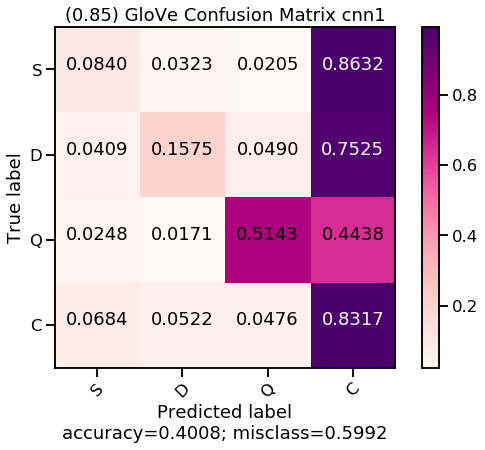

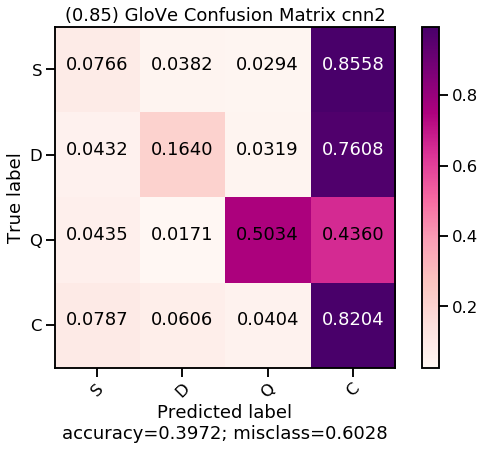

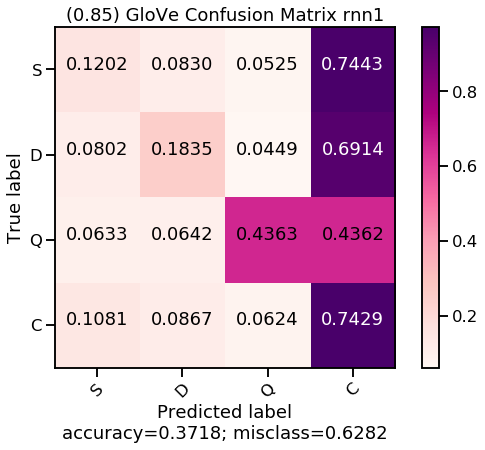

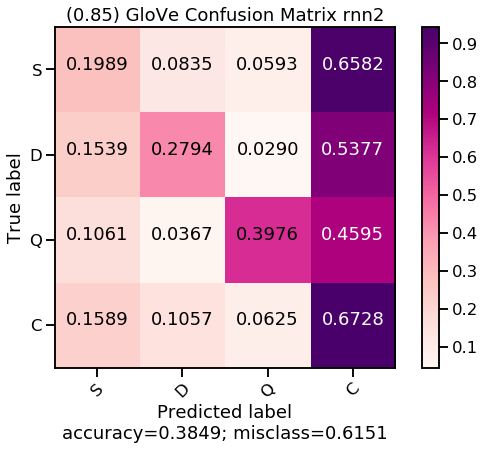

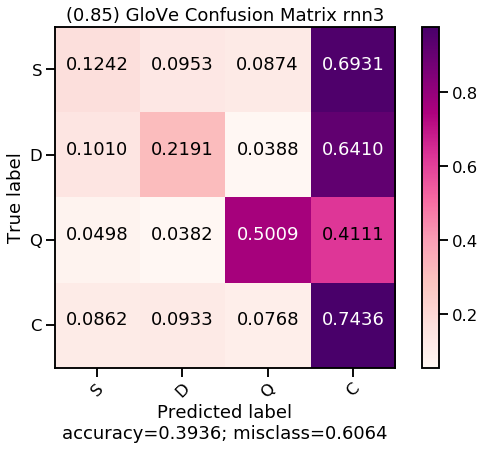

In [31]:
for key in confusions.keys():
    temp=np.sum(confusions[key], axis=0)/5.0
    plot_confusion_matrix(temp, ['S','D','Q','C'], "(0.85) GloVe Confusion Matrix "+str(key), cmap='RdPu')